In [1]:
import pandas as pd
import tensorboard as tb
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorboard.data.experimental import ExperimentFromDev
import re
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.lines import Line2D

In [2]:
def load_experiment_scalars_to_dataframe(experiment_id: str) -> pd.DataFrame:
    # Get the experiment data
    experiment_data = ExperimentFromDev(experiment_id)

    # Get the scalars
    scalars_data = experiment_data.get_scalars(include_wall_time=True)

    # Convert the scalar data to a Pandas DataFrame
    return pd.DataFrame(scalars_data)

In [3]:
def update_tag(row):
    if row['run'] in ['train', 'validation']:
        return f"{row['run']}_{row['tag']}"
    else:
        match = re.match(r'\d+/(train|validation)', row['run'])
        if match:
            stripped_run = match.group(1)
            return f"{stripped_run}_{row['tag']}"
        else:
            print(f"'run' value not in ['train','validation']: {row['run']}")
            return row['tag']

In [293]:
def get_PiNet_TF2_data(experiment_id, mergetype):

    batch_data = load_experiment_scalars_to_dataframe(experiment_id)
    batch_data['wall_time'] += 3600 # for some reason the wall_times were an hour behind
    epoch_data = batch_data[batch_data['tag'].isin(['epoch_loss', 'epoch_mean_absolute_error', 'epoch_mean_squared_error', 'epoch_learning_rate'])]
    epoch_data_indices = epoch_data.index
    batch_data = batch_data.drop(epoch_data_indices)

    # Epoch data
    epoch_data['tag'] = epoch_data.apply(update_tag, axis=1)
    epoch_data.drop(columns=['run'], inplace=True)

    tags = [
        'train_epoch_learning_rate', 'train_epoch_loss',
        'train_epoch_mean_absolute_error',
        'train_epoch_mean_squared_error', 'validation_epoch_loss',
        'validation_epoch_mean_absolute_error',
        'validation_epoch_mean_squared_error'
    ]

    tag_dfs = []

    # Create a DataFrame for each tag and store them in a list
    for tag in tags:
        tag_df = epoch_data[epoch_data['tag'] == tag]
        tag_df = tag_df.rename(columns={'value': tag})
        tag_df = tag_df.drop(columns=['tag'])
        tag_dfs.append(tag_df)


    merged_epoch_data = tag_dfs[0]

    for i in range(1, len(tag_dfs)):

        merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')

    wall_time_column_indices = [i for i, col in enumerate(merged_epoch_data.columns) if 'wall_time' in col]
    merged_epoch_data.columns.values[wall_time_column_indices[0]] = 'wall_time'
    wall_time_column_indices = wall_time_column_indices[1:]
    merged_epoch_data = merged_epoch_data.iloc[:, [i for i, col in enumerate(merged_epoch_data.columns) if i not in wall_time_column_indices]]
    merged_epoch_data['step'] += 1 # Start epoch indexing at 1
    merged_epoch_data.set_index('step', inplace=True)


   
     # Batch data
    # Check if 'RAM_usage_MB' and 'Swap_usage_MB' are present in batch_data['tag']
    ram_usage_present = 'batch_ram_usage_mb' in batch_data['tag'].unique()
    swap_usage_present = 'batch_swap_usage_mb' in batch_data['tag'].unique()

    # Construct the tags list
    tags = [
    'batch_mean_squared_error',
    'batch_mean_absolute_error',
    'batch_loss',
    'batch_moleculespersec',
    'evaluation_loss_vs_iterations',
    'evaluation_mean_absolute_error_vs_iterations',
    'evaluation_mean_squared_error_vs_iterations'
    ]

    # Conditionally add 'RAM_usage_MB' and 'Swap_usage_MB' to the tags list
    if ram_usage_present:
        tags.append('batch_ram_usage_mb')
    if swap_usage_present:
        tags.append('batch_swap_usage_mb')
    
    


    tag_dfs = []

    # Create a DataFrame for each tag and store them in a list
    for tag in tags:
        tag_df = batch_data[batch_data['tag'] == tag]
        tag_df = tag_df.sort_values('wall_time')
        tag_df = tag_df.rename(columns={'value': tag})
        tag_df = tag_df.drop(columns=['run', 'tag'])
        tag_dfs.append(tag_df)


    merged_batch_data = tag_dfs[0]

    for i in range(1, len(tag_dfs)):

        merged_batch_data = pd.merge(merged_batch_data, tag_dfs[i], on='step', how=mergetype)

    wall_time_column_indices = [i for i, col in enumerate(merged_batch_data.columns) if 'wall_time' in col]
    merged_batch_data.columns.values[wall_time_column_indices[0]] = 'wall_time'
    wall_time_column_indices = wall_time_column_indices[1:]
    merged_batch_data = merged_batch_data.iloc[:, [i for i, col in enumerate(merged_batch_data.columns) if i not in wall_time_column_indices]]
    merged_batch_data.set_index('step', inplace=True)


    return merged_epoch_data, merged_batch_data


In [5]:
def get_pwr_data(filepath):
    
    pwrdata = pd.read_csv(filepath)

    # Extract the date from the file name
    date_string = filepath[filepath.find('2023'): filepath.find('2023') + 10]

    # Convert the 'System Time' column to a pandas datetime object
    pwrdata['System Time'] = pd.to_datetime(pwrdata['System Time'], format='%H:%M:%S.%f')

    # Add the date to the 'System Time' column
    pwrdata['System Time'] = pwrdata['System Time'].apply(lambda x: x.replace(year=int(date_string[:4]), month=int(date_string[5:7]), day=int(date_string[8:])))

    # Determine if the date needs to be updated
    if pwrdata['System Time'].iloc[-1].hour < pwrdata['System Time'].iloc[0].hour:
        # Fix the date change issue
        pwrdata['System Time'] = pwrdata['System Time'].apply(lambda x: x + pd.Timedelta(days=1) if x.hour < pwrdata['System Time'].iloc[0].hour else x)
    pwrdata['System Time']

    pwrdata['System Time'] = pwrdata['System Time'].apply(lambda x: pd.to_datetime(x))
    pwrdata['System Time'] = pwrdata['System Time'].apply(lambda x: x.timestamp())
    pwrdata.rename(columns={'System Time': 'wall_time'}, inplace=True)

    return pwrdata

In [6]:
def merge_with_pwr_data(dataframe, pwrdata):
    
    batch_and_pwr_data = pd.merge_asof(dataframe, pwrdata, on='wall_time', direction='nearest')
    batch_and_pwr_data['wall_time'] -= batch_and_pwr_data['wall_time'].iloc[0]
    batch_and_pwr_data.rename(columns={'wall_time': 'Elapsed Time'}, inplace=True)

    return batch_and_pwr_data

In [7]:
def find_non_monotonic_indices(dataframe, column='wall_time'):
    non_monotonic_indices = []
    previous_value = dataframe.iloc[0][column]
    
    for i in range(1, len(dataframe)):
        current_value = dataframe.iloc[i][column]
        if current_value <= previous_value:
            non_monotonic_indices.append(i)
        previous_value = current_value

    if not non_monotonic_indices:
        print("The column is monotonically increasing.")
    else:
        print("Non-monotonic indices:")
        print(non_monotonic_indices)

In [8]:
def get_spektral_data(experiment_id, mergetype):
    df = load_experiment_scalars_to_dataframe(experiment_id)
    if 'wall_time' in df['tag'].unique():
        df_filtered = df[df['tag'] != 'wall_time']
    else:
        df_filtered = df.copy()
    
        # Check if 'RAM_usage_MB' and 'Swap_usage_MB' are present in df['tag']
    ram_usage_present = 'RAM_usage_MB' in df['tag'].unique()
    swap_usage_present = 'Swap_usage_MB' in df['tag'].unique()

    # Construct the tags list
    tags = ['epoch_validation_Loss', 'epoch_validation_MAE',
            'epoch_validation_RMSE', 'batch_Loss', 'batch_MAE', 'batch_RMSE',
            'epoch_Loss', 'epoch_MAE', 'epoch_RMSE', 'epoch_moleculespersec']

    # Conditionally add 'RAM_usage_MB' and 'Swap_usage_MB' to the tags list
    if ram_usage_present:
        tags.append('RAM_usage_MB')
    if swap_usage_present:
        tags.append('Swap_usage_MB')

    tag_dfs = []

    # Create a DataFrame for each tag and store them in a list
    for tag in tags:
        tag_df = df_filtered[df_filtered['tag'] == tag]
        # tag_df = tag_df.sort_values('wall_time')
        tag_df = tag_df.rename(columns={'value': tag})
        tag_df = tag_df.drop(columns=['run', 'tag'])
        tag_dfs.append(tag_df)

    # Merge DataFrames based on the closest wall_time values
    merged_df_step = tag_dfs[0]

    for i in range(1, len(tag_dfs)):
        if i == 3:  # For the fourth dataframe (df4)
            merged_df_step = pd.merge(merged_df_step, tag_dfs[i], on=['step', 'wall_time'], how=mergetype)
        else:
            merged_df_step = pd.merge(merged_df_step, tag_dfs[i].drop(columns='wall_time'), on='step', how=mergetype)

    merged_df_step = merged_df_step.sort_values(by='step').reset_index(drop=True)
    merged_df_step['wall_time'] += 3600

    find_non_monotonic_indices(merged_df_step)

    merged_df_step.set_index('step', inplace=True)

    return merged_df_step

In [9]:
def get_NVIDIA_GPU_data(filepath):

    gpudata = pd.read_csv(filepath)
    gpudata['timestamp']
    gpudata['timestamp'] = gpudata['timestamp'].apply(lambda x: pd.to_datetime(x))
    gpudata['timestamp'] = gpudata['timestamp'].apply(lambda x: x.timestamp())
    gpudata.rename(columns={'timestamp': 'wall_time'}, inplace=True)

    return gpudata

In [11]:
def save_plot(name):
    output_directory = '/Users/miguelnavaharris/New_Benchmarks/newplots'
    output_filename = name
    print(output_filename)
    output_path = os.path.join(output_directory, output_filename)
    plt.savefig(output_path, format='png', dpi=300, bbox_inches='tight')

# Making figures

## Prediction accuracy over multiple epoch scales

In [10]:
colour_map = {'Pinet': '#6ea46e', 'Spektral': '#d0914a'}

In [ ]:
# These were all run on NVIDIA
pinet_1_epoch, pinet_1_batch = get_PiNet_TF2_data('lpVUYx3aRlSduBToaR713g', 'left') 
pinet_10_epochs, pinet_10_batch = get_PiNet_TF2_data('IJjXkUoZSxGxHRKuqHNRxw', 'left')
pinet_100_epoch, pinet_100_batch = get_PiNet_TF2_data('cEFNImENQY6V1Q9XHZwDsg', 'left')


spektral_1 = get_spektral_data('rk4I67NlS1uY0jkMVLjvHA', 'outer')
spektral_10 = get_spektral_data('Y2mY5ZndQVCB4wN3LTGMNQ', 'outer')
spektral_100 = get_spektral_data('B8pwi70OR5ynopUrUMVxcg', 'outer')

In [241]:
spektral_500 = get_spektral_data('w3t8A93pR1y3nwKvg4ltlw', 'outer')
spektral_296 = get_spektral_data('spkLmzN1QluV8bkzQN4aQA', 'outer')

Non-monotonic indices:
[438, 1755, 2633, 3072, 3511, 4828, 5267, 6584, 7023, 7462, 7901, 9218, 9657, 10096]
Non-monotonic indices:
[438, 1755, 3511, 4389, 4828, 5267]


In [288]:
# Comment out the batch tags in get_PiNet_TF2_data if you want this to work properly
pinet_400_epoch, pinet_400_batch = get_PiNet_TF2_data('z7Gq1UJdTAeBy62ZizvmLg', 'left')

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/2849137309.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/2849137309.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')


Optimal Training Epochs via Validation Loss Monitoring


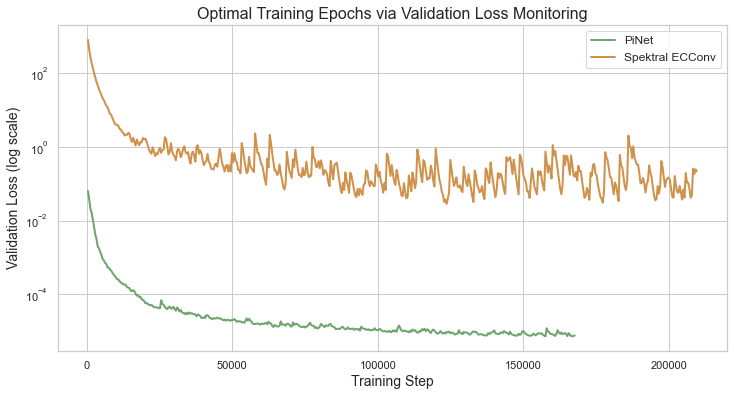

In [297]:
spektral_500_valid_index = spektral_500['epoch_validation_Loss'].dropna().index
spektral_500_valid_data = spektral_500['epoch_validation_Loss'].dropna()
pinet_400_valid_data = pinet_400_batch['evaluation_loss_vs_iterations'].dropna()
pinet_400_valid_index = pinet_400_batch['evaluation_mean_squared_error_vs_iterations'].dropna().index

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.5
pinet_400_valid_data_ewma = pinet_400_valid_data.ewm(alpha=ewma_alpha).mean()
spektral_500_valid_data_ewma = spektral_500_valid_data.ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(pinet_400_valid_index, pinet_400_valid_data_ewma, label='PiNet', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_500_valid_index, spektral_500_valid_data_ewma, label='Spektral ECConv', color=colour_map['Spektral'], linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Validation Loss (log scale)', fontsize=14)
ax.set_title('Optimal Training Epochs via Validation Loss Monitoring', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
validation_plot_10 = fig
save_plot('Optimal Training Epochs via Validation Loss Monitoring')
# To display the plot
plt.show()

In [14]:
# 1 epoch validation errors
pinet_1_validation_error = pinet_1_batch['evaluation_loss_vs_iterations'].dropna().iloc[0]
spektral_1_validation_error = spektral_1['epoch_validation_Loss'].dropna().iloc[0]

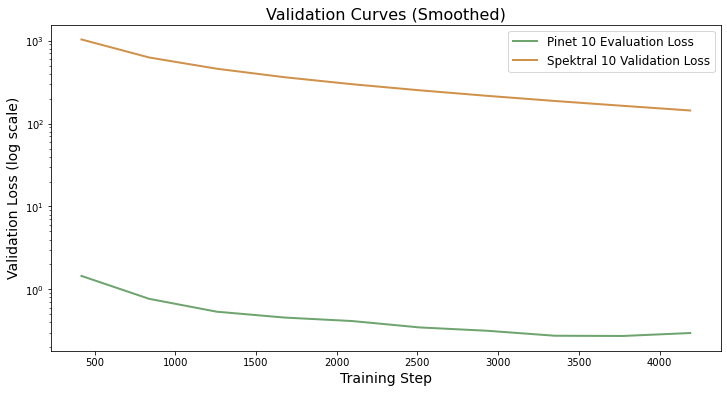

In [15]:
# Plot validation curves for 10 epochs
pinet_10_valid_data = pinet_10_batch['evaluation_loss_vs_iterations'].dropna()
pinet_10_valid_index = pinet_10_batch['evaluation_mean_squared_error_vs_iterations'].dropna().index

spektral_10_valid_index = spektral_10['epoch_validation_Loss'].dropna().index
spektral_10_valid_data = spektral_10['epoch_validation_Loss'].dropna()

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.1
pinet_10_valid_data_ewma = pinet_10_valid_data.ewm(alpha=ewma_alpha).mean()
spektral_10_valid_data_ewma = spektral_10_valid_data.ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(pinet_10_valid_index, pinet_10_valid_data_ewma, label='Pinet 10 Evaluation Loss', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_10_valid_index, spektral_10_valid_data_ewma, label='Spektral 10 Validation Loss', color=colour_map['Spektral'], linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Validation Loss (log scale)', fontsize=14)
ax.set_title('Validation Curves (Smoothed)', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
validation_plot_10 = fig

# To display the plot
plt.show()

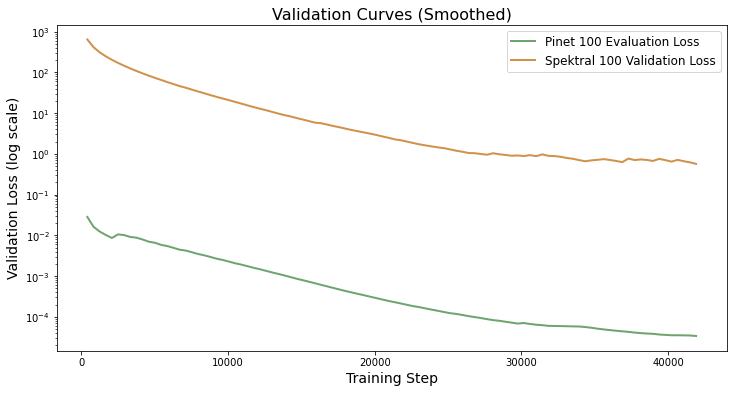

In [16]:
# Plot validation curves for 100 epochs
pinet_100_valid_data = pinet_100_batch['evaluation_loss_vs_iterations'].dropna()
pinet_100_valid_index = pinet_100_batch['evaluation_mean_squared_error_vs_iterations'].dropna().index

spektral_100_valid_index = spektral_100['epoch_validation_Loss'].dropna().index
spektral_100_valid_data = spektral_100['epoch_validation_Loss'].dropna()

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.1
pinet_100_valid_data_ewma = pinet_100_valid_data.ewm(alpha=ewma_alpha).mean()
spektral_100_valid_data_ewma = spektral_100_valid_data.ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(pinet_100_valid_index, pinet_100_valid_data_ewma, label='Pinet 100 Evaluation Loss', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_100_valid_index, spektral_100_valid_data_ewma, label='Spektral 100 Validation Loss', color=colour_map['Spektral'], linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Validation Loss (log scale)', fontsize=14)
ax.set_title('Validation Curves (Smoothed)', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
validation_plot_100 = fig

# To display the plot
plt.show()

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/2710106439.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pinet_1_batch_filtered = pinet_1_batch.iloc[19::20, :].append(pinet_1_batch.iloc[-1])


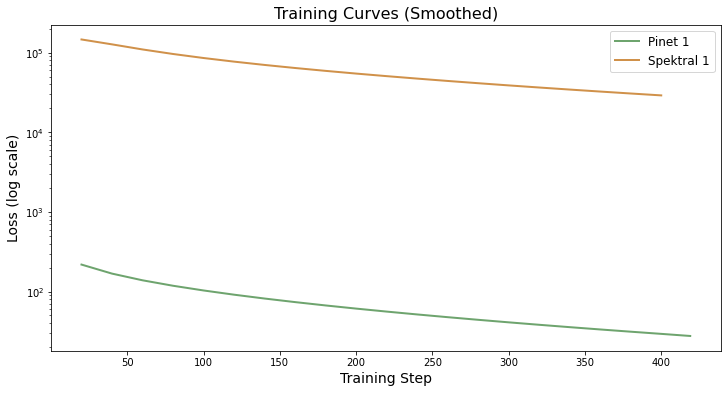

In [17]:
# Plot Training curves for 1 epochs
# Spektral batch_Loss contains some NaN values due to outer merge with validation data. Need to drop these to avoid gaps in graph.
spektral_1_train_data = spektral_1['batch_Loss'].dropna()
pinet_1_batch_filtered = pinet_1_batch.iloc[19::20, :].append(pinet_1_batch.iloc[-1])

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.1
spektral_1_train_data_ewma = spektral_1_train_data.ewm(alpha=ewma_alpha).mean()
pinet_1_batch_filtered_ewma = pinet_1_batch_filtered['batch_mean_squared_error'].ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(pinet_1_batch_filtered.index, pinet_1_batch_filtered_ewma, label='Pinet 1', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_1_train_data.index, spektral_1_train_data_ewma, label='Spektral 1', color=colour_map['Spektral'], linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Loss (log scale)', fontsize=14)
ax.set_title('Training Curves (Smoothed)', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
training_plot_1 = fig

# To display the plot
plt.show()

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/2265542554.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pinet_10_batch_filtered = pinet_10_batch.iloc[19::20, :].append(pinet_10_batch.iloc[-1])


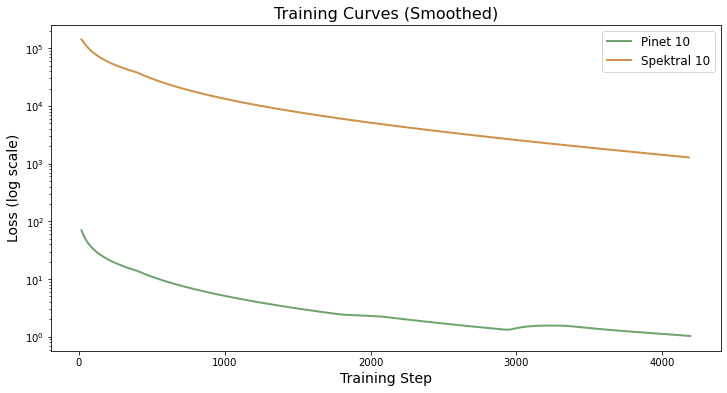

In [18]:
# Plot Training curves for 10 epochs
# Spektral batch_Loss contains some NaN values due to outer merge with validation data. Need to drop these to avoid gaps in graph.
spektral_10_train_data = spektral_10['batch_Loss'].dropna()
pinet_10_batch_filtered = pinet_10_batch.iloc[19::20, :].append(pinet_10_batch.iloc[-1])

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.01
spektral_10_train_data_ewma = spektral_10_train_data.ewm(alpha=ewma_alpha).mean()
pinet_10_batch_filtered_ewma = pinet_10_batch_filtered['batch_mean_squared_error'].ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
ax.plot(pinet_10_batch_filtered.index, pinet_10_batch_filtered_ewma, label='Pinet 10', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_10_train_data.index, spektral_10_train_data_ewma, label='Spektral 10', color=colour_map['Spektral'], linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Loss (log scale)', fontsize=14)
ax.set_title('Training Curves (Smoothed)', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
training_plot_10 = fig

# To display the plot
plt.show()

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/482936182.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pinet_100_batch_filtered = pinet_100_batch.iloc[19::20, :].append(pinet_100_batch.iloc[-1])


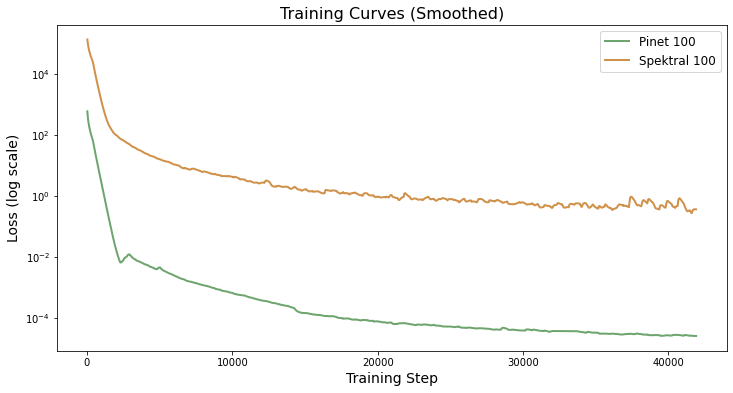

In [19]:
# Plot Training curves for 100 epochs
# Spektral batch_Loss contains some NaN values due to outer merge with validation data. Need to drop these to avoid gaps in graph.
spektral_100_train_data = spektral_100['batch_Loss'].dropna()
pinet_100_batch_filtered = pinet_100_batch.iloc[19::20, :].append(pinet_100_batch.iloc[-1])

# Apply EWMA with a 0.1 alpha value
ewma_alpha = 0.1
spektral_100_train_data_ewma = spektral_100_train_data.ewm(alpha=ewma_alpha).mean()
pinet_100_batch_filtered_ewma = pinet_100_batch_filtered['batch_mean_squared_error'].ewm(alpha=ewma_alpha).mean()

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(12, 6))



# Plot the data
ax.plot(pinet_100_batch_filtered.index, pinet_100_batch_filtered_ewma, label='Pinet 100', color=colour_map['Pinet'], linewidth=2)
ax.plot(spektral_100_train_data.index, spektral_100_train_data_ewma, label='Spektral 100', color=colour_map['Spektral'],linewidth=2)

ax.set_yscale('log')
ax.set_xlabel('Training Step', fontsize=14)
ax.set_ylabel('Loss (log scale)', fontsize=14)
ax.set_title('Training Curves (Smoothed)', fontsize=16)
ax.legend(fontsize=12)
# ax.grid(True, which='both', linestyle='--', alpha=0.7)

# Save the figure in a variable
training_plot_100 = fig

# To display the plot
plt.show()

Training and Validation Performance Across Multiple Epoch Scales


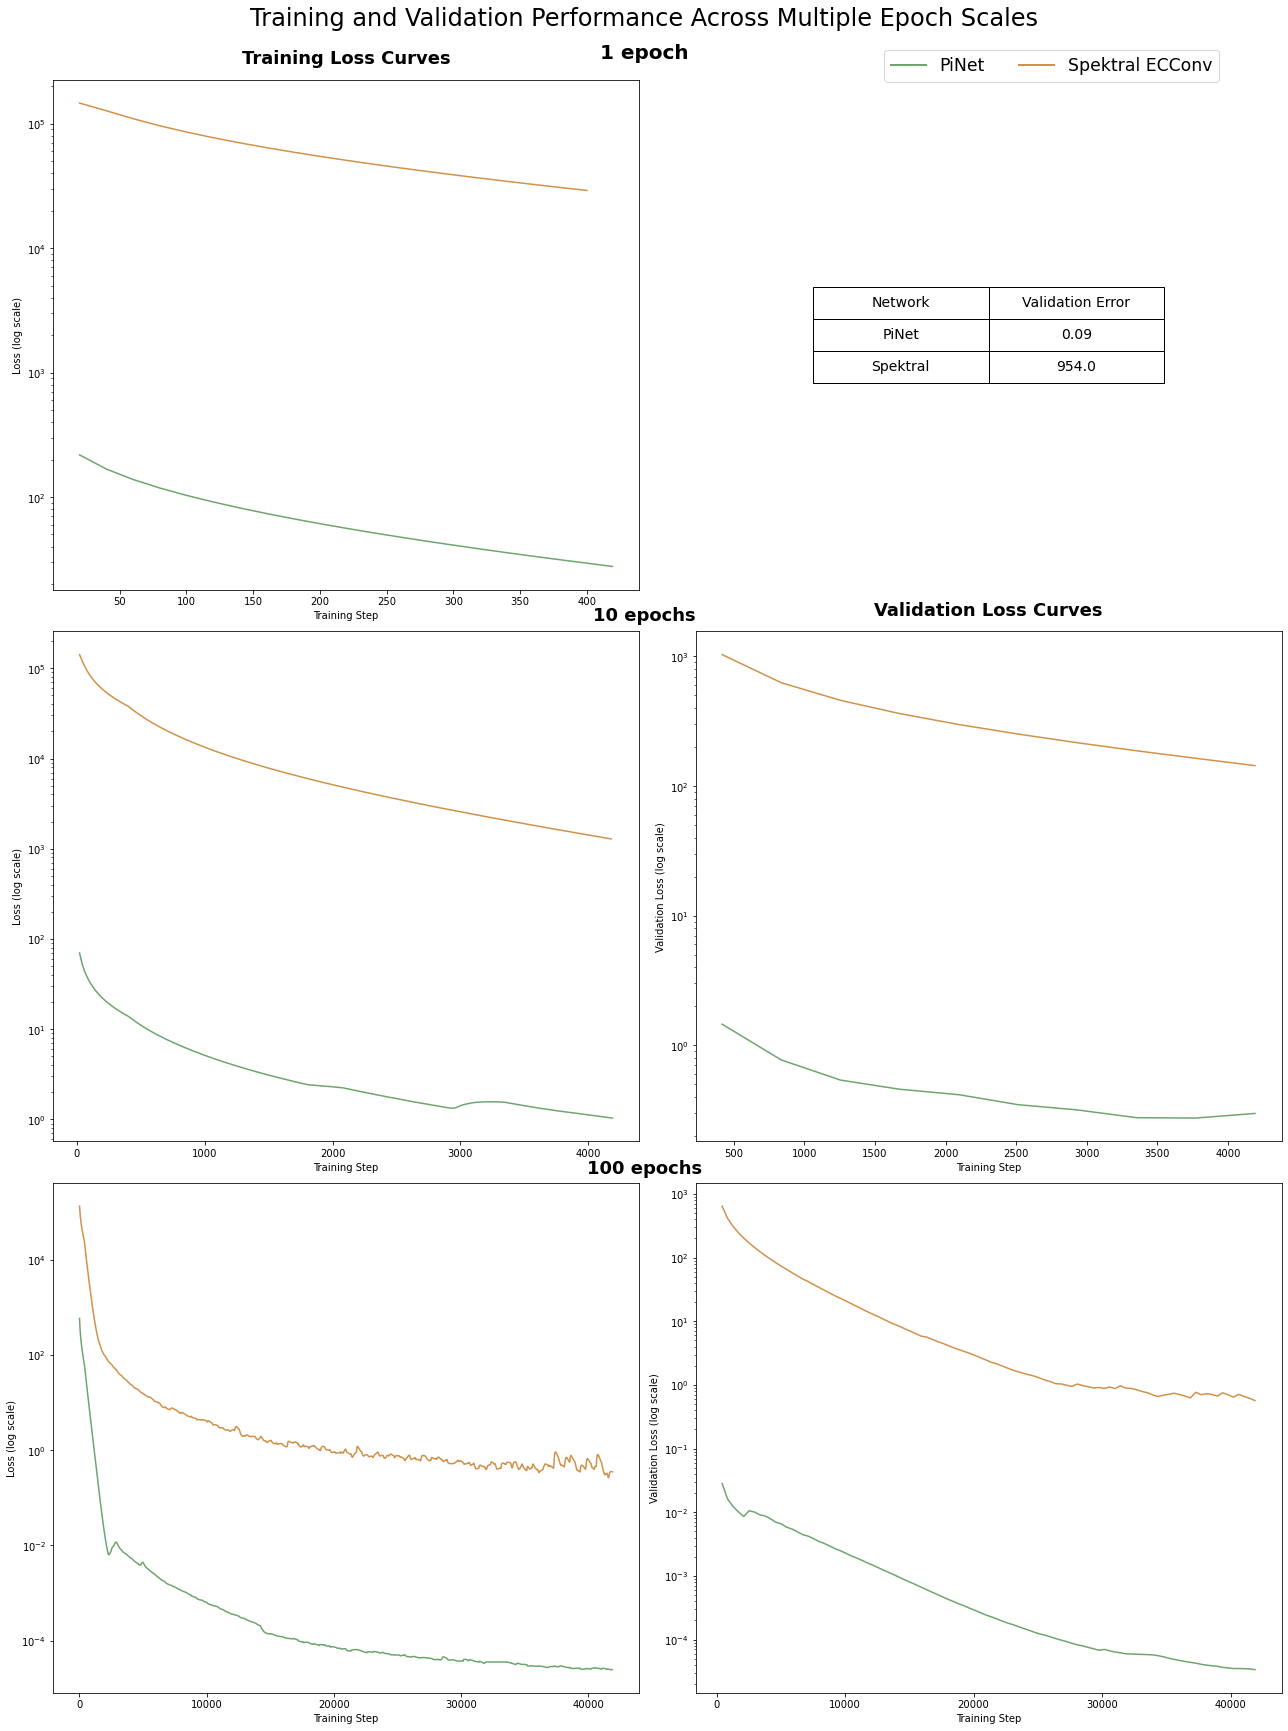

In [21]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))

# Function to copy a plot to a new axis
def copy_plot(source_ax, target_ax):
    for line in source_ax.get_lines():
        target_ax.plot(line.get_xdata(), line.get_ydata(), label=line.get_label(), color=line.get_color())
    target_ax.set_yscale('log')
    target_ax.set_xlabel(source_ax.get_xlabel())
    target_ax.set_ylabel(source_ax.get_ylabel())
    # target_ax.set_title(source_ax.get_title())

# First row: 1 epoch
copy_plot(training_plot_1.axes[0], axes[0, 0])

validation_errors = pd.DataFrame({'Network': ['PiNet', 'Spektral'],
                                  'Validation Error': [round(pinet_1_validation_error, 2), int(round(spektral_1_validation_error))]})

axes[0, 1].axis('off')
table = axes[0, 1].table(cellText=validation_errors.values,
                         colLabels=validation_errors.columns,
                         cellLoc='center',
                         loc='center',
                         colWidths=[0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 2)
# Second row: 10 epochs
copy_plot(training_plot_10.axes[0], axes[1, 0])
copy_plot(validation_plot_10.axes[0], axes[1, 1])

# Third row: 100 epochs
copy_plot(training_plot_100.axes[0], axes[2, 0])
copy_plot(validation_plot_100.axes[0], axes[2, 1])

axes[0, 0].set_title('Training Loss Curves', fontsize=18, weight='bold', y=1.02)
axes[1, 1].set_title('Validation Loss Curves', fontsize=18, weight='bold', y=1.02)


fig.text(0.5, 0.97, '1 epoch', fontsize=20, weight='bold', ha='center')
fig.text(0.5, 0.645, '10 epochs', fontsize=18, weight='bold', ha='center')
fig.text(0.5, 0.325, '100 epochs', fontsize=18, weight='bold', ha='center')


# Add a title for the whole figure
fig.suptitle('Training and Validation Performance Across Multiple Epoch Scales', fontsize=24, y=1)

legend_labels_colors = {'PiNet': '#6ea46e', 'Spektral ECConv': '#d0914a'}
custom_lines = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in legend_labels_colors.items()]
fig.legend(custom_lines, [line.get_label() for line in custom_lines], loc='upper right', ncol=len(custom_lines), fontsize='xx-large', bbox_to_anchor=(0.95, 0.98))

plt.tight_layout()
save_plot('Training and Validation Performance Across Multiple Epoch Scales')
plt.show()


## M1 batch size training times & swap build

In [22]:
PiNet_TF2_M1_GPU_1024_epoch, PiNet_TF2_M1_GPU_1024_batch  = get_PiNet_TF2_data('3yzGKeSWQ6i14idrTbYYFg', 'left')
PiNet_TF2_M1_GPU_512_epoch, PiNet_TF2_M1_GPU_512_batch = get_PiNet_TF2_data('3CB84VjcQnOvOvXOjGuBmA', 'left')
PiNet_TF2_M1_GPU_256_epoch, PiNet_TF2_M1_GPU_256_batch = get_PiNet_TF2_data('OndD5UWpTMmh5VkZ6MBbtw', 'left')
PiNet_TF2_M1_GPU_128_epoch, PiNet_TF2_M1_GPU_128_batch = get_PiNet_TF2_data('bGAIzWPUQWabenh6V6gVyA', 'left')

Spektral_M1_GPU_lrdecay_10epochs_1024 = get_spektral_data('lDqpJbVaS2aJblcXV1masA', 'outer')
Spektral_M1_GPU_lrdecay_10epochs_512 = get_spektral_data('ynueARoGTMOXTKLQ0QuZXw', 'outer')
Spektral_M1_GPU_lrdecay_10epochs_256 = get_spektral_data('903sQ50RR76H8e04RoBvsA', 'outer')
Spektral_M1_GPU_lrdecay_10epochs_128 = get_spektral_data('mK5lEAeiRw20zPjPcgKnBQ', 'outer')
Spektral_M1_GPU_lrdecay_10epochs_64 = get_spektral_data('5DrwAZOvTryO9HBqy1O8MA', 'outer') # crashed after 8 epochs


/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:86: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_batch_data = pd.merge(merged_batch_data, tag_dfs[i], on='step', how=mergetype)
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq

Non-monotonic indices:
[49]
Non-monotonic indices:
[22, 45, 68]
The column is monotonically increasing.
The column is monotonically increasing.
The column is monotonically increasing.


In [23]:
pinet_batch_dfs = [PiNet_TF2_M1_GPU_1024_batch, PiNet_TF2_M1_GPU_512_batch, PiNet_TF2_M1_GPU_256_batch, PiNet_TF2_M1_GPU_128_batch]
spektral_batch_dfs = [Spektral_M1_GPU_lrdecay_10epochs_1024, Spektral_M1_GPU_lrdecay_10epochs_512, Spektral_M1_GPU_lrdecay_10epochs_256, Spektral_M1_GPU_lrdecay_10epochs_128, Spektral_M1_GPU_lrdecay_10epochs_64]

In [25]:
def extract_traintime_pinet(df):
    df['wall_time'] -= df['wall_time'].iloc[0]
    return df['wall_time'].iloc[-1]

def extract_traintime_spektral(df, epochs):
    epoch_index = df['epoch_validation_MAE'].dropna().index[epochs - 1]
    wall_time = df['wall_time'].loc[epoch_index] - df['wall_time'].iloc[0]
    return wall_time

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/4175794686.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append({
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/4175794686.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append({
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/4175794686.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_df.append({
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/4175794686.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_df = combined_

M1 GPU: 3-epoch training time vs batch size


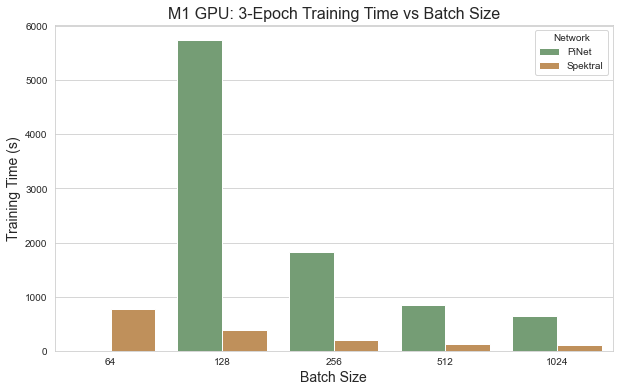

In [27]:
# Create lists of dataframes with manual batch sizes
pinet_batch_sizes = [1024, 512, 256, 128]
spektral_batch_sizes = [1024, 512, 256, 128, 64]

# Create the combined dataframe with the new extract_traintime_spektral function
combined_df = pd.DataFrame(columns=['Network', 'batch_size', 'training_time'])

for Network, batch_dfs, batch_sizes in [('PiNet', pinet_batch_dfs, pinet_batch_sizes), ('Spektral', spektral_batch_dfs, spektral_batch_sizes)]:
    for df, batch_size in zip(batch_dfs, batch_sizes):
        if Network == 'Spektral':
            training_time = extract_traintime_spektral(df, 3)  # Get wall_time after 3 epochs for Spektral dataframes
        else:
            training_time = extract_traintime_pinet(df)  # Get the total training time for PiNet dataframes

        combined_df = combined_df.append({
            'Network': Network,
            'batch_size': batch_size,
            'training_time': training_time
        }, ignore_index=True)

# Plot the bar chart
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=combined_df, x='batch_size', y='training_time', hue='Network', palette=colour_map.values())
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Training Time (s)', fontsize=14)
plt.title('M1 GPU: 3-Epoch Training Time vs Batch Size', fontsize=16)
save_plot('M1 GPU: 3-epoch training time vs batch size')
plt.show()


In [298]:
def extract_memory_use_spektral(df, epochs):
    epoch_index = df['epoch_validation_MAE'].dropna().index[epochs - 1]
    return df[['RAM_usage_MB', 'Swap_usage_MB']].loc[:epoch_index]


# Function to create a memory usage dataframe for plotting
def create_memory_usage_df(network, batch_dfs, batch_sizes):
    memory_dfs = []
    
    for df, batch_size in zip(batch_dfs, batch_sizes):
        if network == 'Spektral':
            memory_usage = extract_memory_use_spektral(df, 3)
        else:
            memory_usage = df[['batch_ram_usage_mb', 'batch_swap_usage_mb']]

        memory_usage = memory_usage.reset_index().rename(columns={'index': 'training_step'})
        memory_usage['network'] = network
        memory_usage['batch_size'] = batch_size
        memory_usage.columns = ['training_step', 'RAM_usage_MB', 'Swap_usage_MB', 'network', 'batch_size']
        memory_dfs.append(memory_usage)

    return pd.concat(memory_dfs, ignore_index=True)

# Create separate memory usage dataframes for PiNet and Spektral
pinet_memory_df = create_memory_usage_df('PiNet', pinet_batch_dfs, pinet_batch_sizes)
spektral_memory_df = create_memory_usage_df('Spektral', spektral_batch_dfs, spektral_batch_sizes)

# Function to plot memory usage for a given network and batch size
def plot_memory_usage(df, network, batch_size):
    df_batch = df[df['batch_size'] == batch_size]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_batch, x='training_step', y='RAM_usage_MB', label='RAM Usage (MB)')
    sns.lineplot(data=df_batch, x='training_step', y='Swap_usage_MB', label='Swap Memory Usage (MB)')
    plt.xlabel("Training Step", fontsize=14)
    plt.ylabel("Memory Usage (MB)", fontsize=14)
    plt.title(f"{network} Memory Use Over 3 Epochs (Batch Size: {batch_size})", fontsize=16)
    plt.legend()
    # save_plot(f"{network} Memory Use Over 3 Epochs (Batch Size: {batch_size})")
    plt.show()


PiNet Memory Use Over 3 Epochs (Batch Size: 1024)


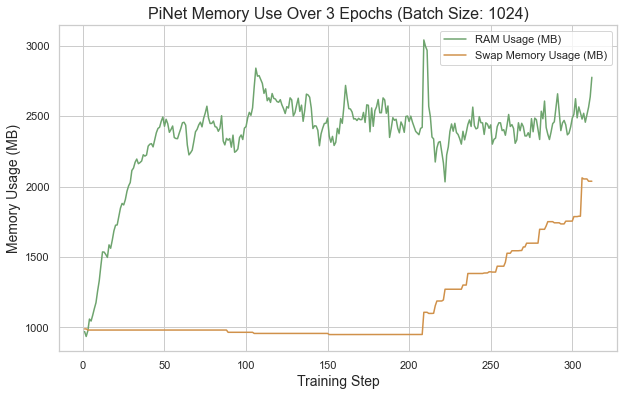

PiNet Memory Use Over 3 Epochs (Batch Size: 512)


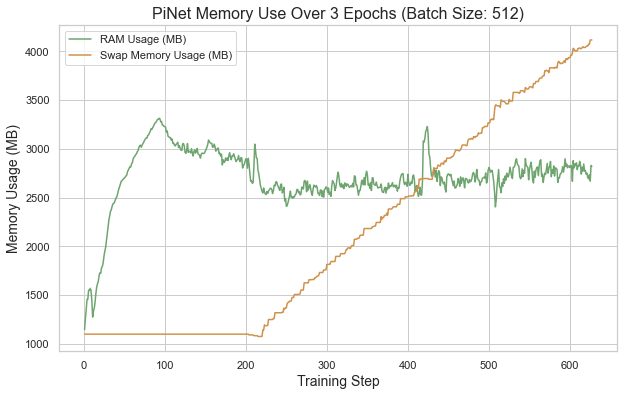

PiNet Memory Use Over 3 Epochs (Batch Size: 256)


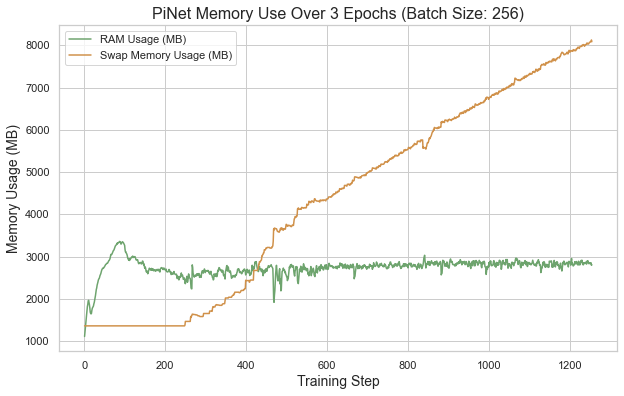

PiNet Memory Use Over 3 Epochs (Batch Size: 128)


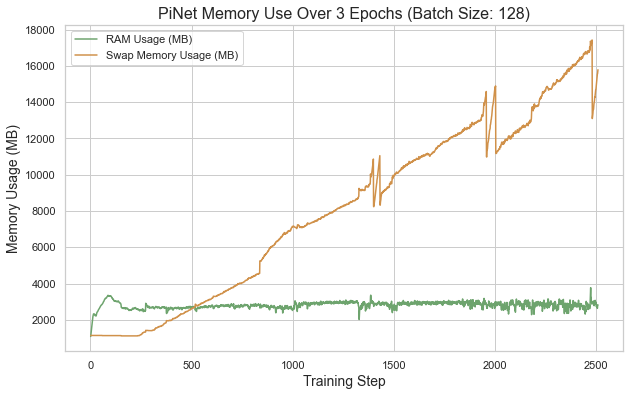

Spektral ECConv Memory Use Over 3 Epochs (Batch Size: 1024)


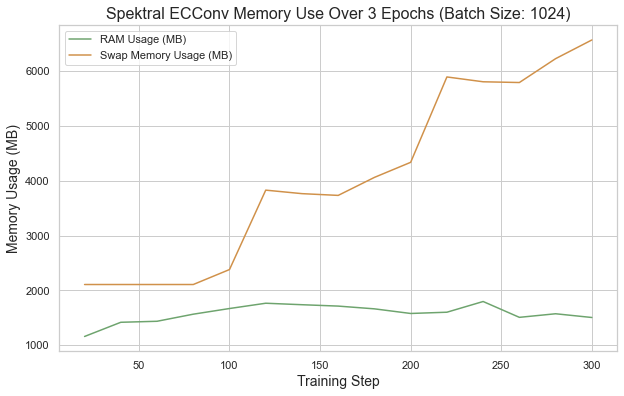

Spektral ECConv Memory Use Over 3 Epochs (Batch Size: 512)


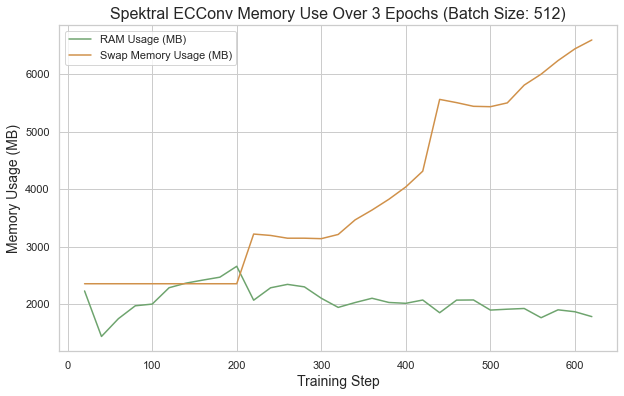

Spektral ECConv Memory Use Over 3 Epochs (Batch Size: 256)


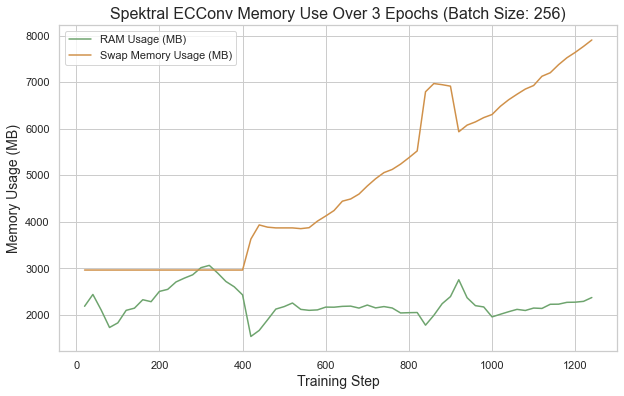

Spektral ECConv Memory Use Over 3 Epochs (Batch Size: 128)


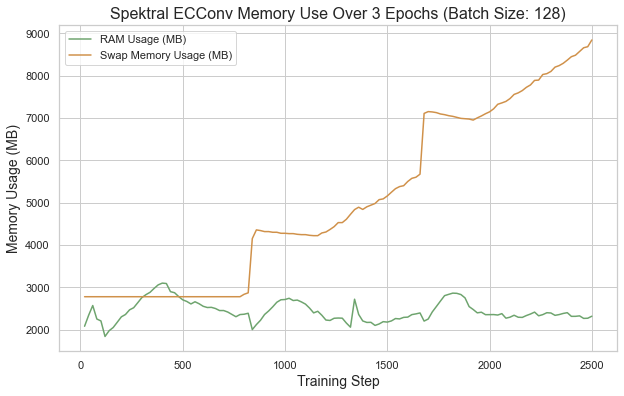

Spektral ECConv Memory Use Over 3 Epochs (Batch Size: 64)


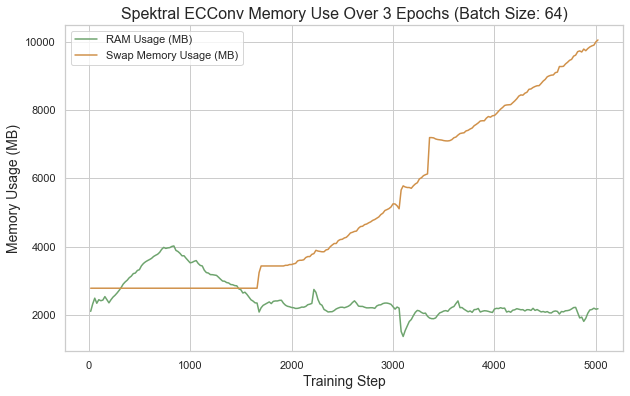

In [69]:
# Create separate memory usage dataframes for PiNet and Spektral
pinet_memory_df = create_memory_usage_df('PiNet', pinet_batch_dfs, pinet_batch_sizes)
spektral_memory_df = create_memory_usage_df('Spektral', spektral_batch_dfs, spektral_batch_sizes)

# Create separate plots for each network and batch size
for batch_size in pinet_batch_sizes:
    plot_memory_usage(pinet_memory_df, 'PiNet', batch_size)

for batch_size in spektral_batch_sizes:
    plot_memory_usage(spektral_memory_df, 'Spektral ECConv', batch_size)

In [30]:
memory_usage = extract_memory_use_spektral(Spektral_M1_GPU_lrdecay_10epochs_1024, 3)
molecules_per_sec = Spektral_M1_GPU_lrdecay_10epochs_1024['epoch_moleculespersec'].dropna().iloc[:3]


PiNet: Training Speed vs Training Step (3 Epochs)


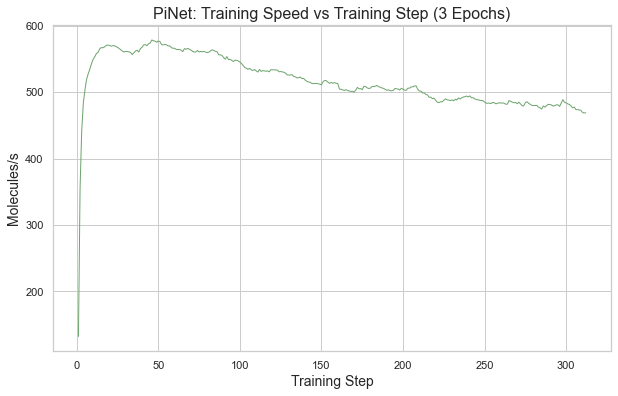

In [32]:
smoothing_factor = 0.1
smoothed_data = PiNet_TF2_M1_GPU_1024_batch['batch_moleculespersec'].ewm(alpha=smoothing_factor).mean()

# Customize the plot appearance
plt.figure(figsize=(10, 6))  # Added figsize for a larger plot
sns.set(style="whitegrid")  # Added Seaborn whitegrid style

# Plot the smoothed data
plt.plot(
    PiNet_TF2_M1_GPU_1024_batch.index,
    smoothed_data,
    linestyle='-',  # Solid line connecting the markers
    linewidth=1,  # Line width
    color='#6ea46e',  # Line and marker color
    label='Molecules/s'  # Added label for the legend
)

plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Molecules/s', fontsize=14)
plt.title('PiNet: Training Speed vs Training Step (3 Epochs)', fontsize=16)
save_plot('PiNet: Training Speed vs Training Step (3 Epochs)')
plt.show()


Spektral: Training Speed vs Training Step (10 Epochs)


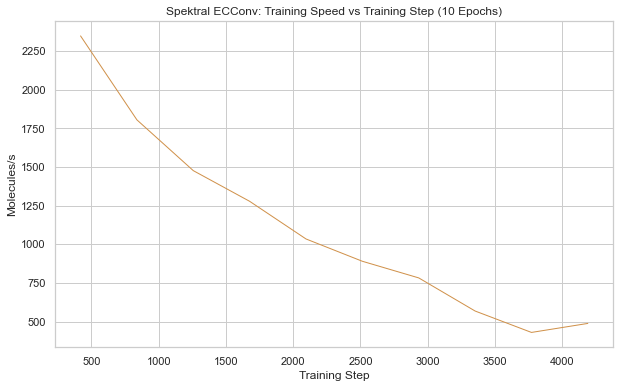

In [72]:
spektral_256_3_epoch_moleculespersec = Spektral_M1_GPU_lrdecay_10epochs_256[Spektral_M1_GPU_lrdecay_10epochs_256['epoch_moleculespersec'].notna()].iloc[:10]


plt.figure(figsize=(10, 6))  # Added figsize for a larger plot
sns.set(style="whitegrid")  # Added Seaborn whitegrid style
# Plot the smoothed data
plt.plot(
    spektral_256_3_epoch_moleculespersec.index,
    spektral_256_3_epoch_moleculespersec['epoch_moleculespersec'],
    linestyle='-',  # Solid line connecting the markers
    linewidth=1,  # Line width
    color='#d0914a',  # Line and marker color
)

# Customize the plot appearance
plt.xlabel('Training Step')
plt.ylabel('Molecules/s')
plt.title('Spektral ECConv: Training Speed vs Training Step (10 Epochs)')
save_plot('Spektral: Training Speed vs Training Step (10 Epochs)')
# Display the plot
plt.show()

## Predicted vs true

### Estimator vs TF2

In [42]:
estimator_pred_1_epoch = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/PiNet_Estimator_optimised_dressnoscale/predvstrue.csv')
pinet_pred_1_epoch = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/PiNet_rescaled_correctly/withgpumetrics/1_epochs_dressnoscale/predvstrue.csv')
estimator_pred_1_epoch.drop(columns='Unnamed: 0', inplace=True)
pinet_pred_1_epoch.drop(columns='Unnamed: 0', inplace=True)

PiNet Estimator vs TF2 Prediction Comparison


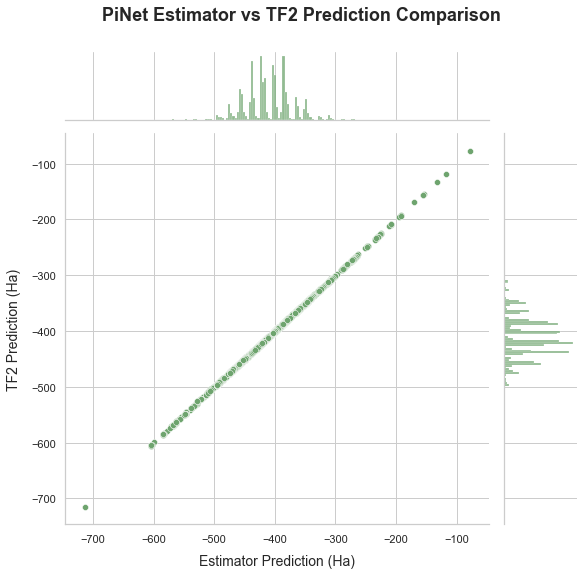

In [43]:
estimatorvstf2_df = pd.DataFrame({'Estimator Predictions': estimator_pred_1_epoch['pred_energy'], 'TF2 Predictions': pinet_pred_1_epoch['pred_energy']})


# Create the jointplot with custom style and colors
sns.set(style="whitegrid")
joint_plot = sns.jointplot(data=estimatorvstf2_df, x='Estimator Predictions', y='TF2 Predictions', 
                           kind='scatter', color='#6ea46e', height=8)

# Set axis labels
joint_plot.set_axis_labels('Estimator Prediction (Ha)', 'TF2 Prediction (Ha)', fontsize=14, labelpad=10)

# Set the title
plt.subplots_adjust(top=0.9)
joint_plot.fig.suptitle('PiNet Estimator vs TF2 Prediction Comparison', fontsize=18, fontweight='bold')

save_plot('PiNet Estimator vs TF2 Prediction Comparison')
# Show the plot
plt.show()

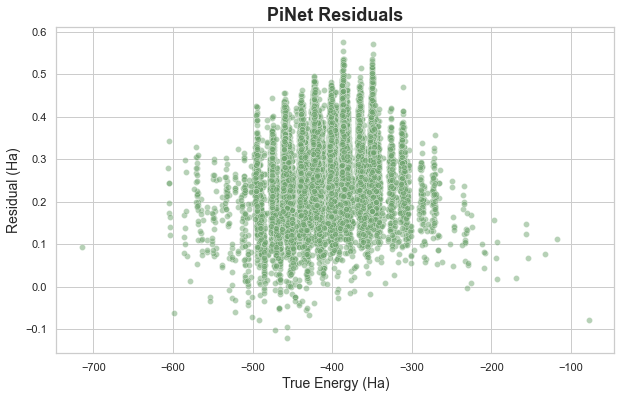

In [270]:
# Calculate residuals for PiNet
pinet_pred_1_epoch['residual'] = pinet_pred_1_epoch['pred_energy'] - estimator_pred_1_epoch['true_energy']

# Create the residuals plot for PiNet
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pinet_pred_1_epoch, x='true_energy', y='residual', color='#6ea46e', alpha=0.5)

plt.xlabel('True Energy (Ha)', fontsize=14)
plt.ylabel('Residual (Ha)', fontsize=14)
plt.title('PiNet Residuals', fontsize=18, fontweight='bold')

# Show the plot
plt.show()

### Optimised models: Prediction accuracy

In [44]:
PiNet_14epochs = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/Prediction_accuracy/M1/Rescaled_correctly/PiNet_14_epochs_256_dressnoscale/predictionvstrue.csv')
Spektral_28epochs = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/Spektral/28_epochs_earlystopping_256_lrdecay/predictionvstrue.csv')
PiNet_14epochs.drop(columns='Unnamed: 0', inplace=True)
Spektral_28epochs.drop(columns='Unnamed: 0', inplace=True)

In [215]:
PiNet_400epochs = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/PiNet_rescaled_correctly/400_epochs_dressnoscale/predvstrue.csv')
Spektral_296epochs = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/Spektral/296_epochs/test/predvstrue.csv')
PiNet_400epochs.drop(columns='Unnamed: 0', inplace=True)
Spektral_296epochs.drop(columns='Unnamed: 0', inplace=True)

PiNet prediction accuracy


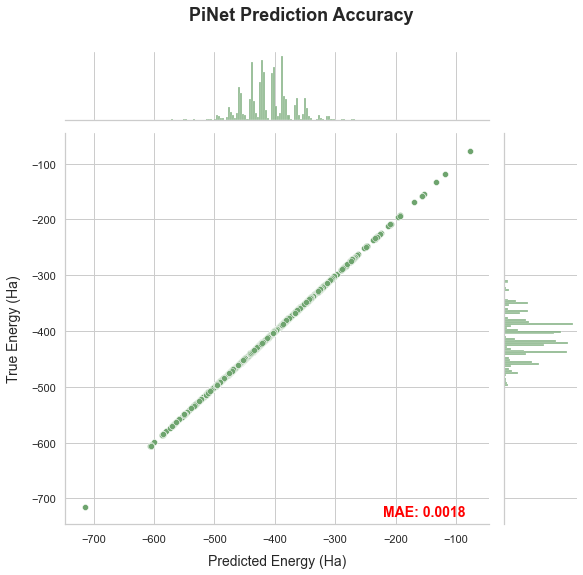

In [226]:
# Create the jointplot with custom style and colors
sns.set(style="whitegrid")
joint_plot = sns.jointplot(data=PiNet_400epochs, x='pred_energy', y='true_energy', 
                           kind='scatter', color='#6ea46e', height=8)

# Set axis labels
joint_plot.set_axis_labels('Predicted Energy (Ha)', 'True Energy (Ha)', fontsize=14, labelpad=10)

# Set the title
plt.subplots_adjust(top=0.9)
joint_plot.fig.suptitle('PiNet Prediction Accuracy', fontsize=18, fontweight='bold')

# Add MAE value to the plot, rounded to 2 significant figures
mae_value = 0.0018341609226712895
rounded_mae = round(mae_value, 4)
joint_plot.ax_joint.annotate(f'MAE: {rounded_mae}', xy=(0.75, 0.05), 
                             xycoords='axes fraction', fontsize=14, 
                             fontweight='bold', color='red', 
                             horizontalalignment='left', verticalalignment='top')

save_plot('PiNet prediction accuracy')
# Show the plot
plt.show()


Spektral prediction accuracy


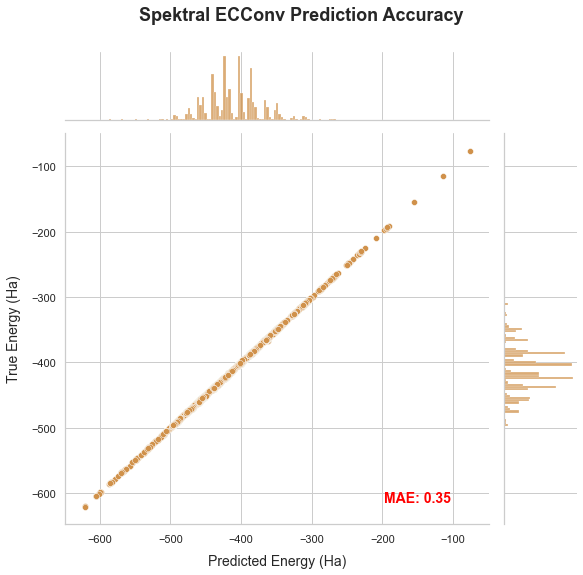

In [230]:
# Create the jointplot with custom style and colors
sns.set(style="whitegrid")
joint_plot = sns.jointplot(data=Spektral_296epochs, x='pred_energy', y='true_energy', 
                           kind='scatter', color='#d0914a', height=8)

# Set axis labels
joint_plot.set_axis_labels('Predicted Energy (Ha)', 'True Energy (Ha)', fontsize=14, labelpad=10)

# Set the title
plt.subplots_adjust(top=0.9)
joint_plot.fig.suptitle('Spektral ECConv Prediction Accuracy', fontsize=18, fontweight='bold')

# Add MAE value to the plot, rounded to 2 significant figures
mae_value = 0.3474268614699752
rounded_mae = round(mae_value, 2)
joint_plot.ax_joint.annotate(f'MAE: {rounded_mae}', xy=(0.91, 0.05), 
                             xycoords='axes fraction', fontsize=14, 
                             fontweight='bold', color='red', 
                             horizontalalignment='right', verticalalignment='bottom')

save_plot('Spektral prediction accuracy')
# Show the plot
plt.show()



Residuals


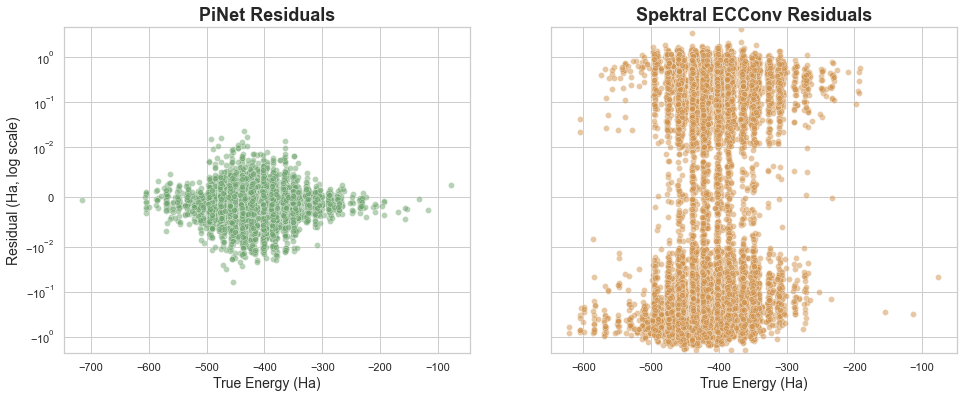

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a subplot with two scatter plots and shared y-axis
fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot the residuals for PiNet
sns.scatterplot(data=PiNet_400epochs, x='true_energy', y='residual', 
                ax=ax[0], color='#6ea46e', alpha=0.5)

ax[0].set_xlabel('True Energy (Ha)', fontsize=14)
ax[0].set_ylabel('Residual (Ha, log scale)', fontsize=14)
ax[0].set_title('PiNet Residuals', fontsize=18, fontweight='bold')

# Plot the residuals for Spektral ECConv
sns.scatterplot(data=Spektral_296epochs, x='true_energy', y='residual', 
                ax=ax[1], color='#d0914a', alpha=0.5)

ax[1].set_xlabel('True Energy (Ha)', fontsize=14)
ax[1].set_ylabel('Residual (Ha, log scale)', fontsize=14)
ax[1].set_title('Spektral ECConv Residuals', fontsize=18, fontweight='bold')

# Set the y-axis to log scale for both plots
ax[0].set_yscale('symlog', linthresh=0.01)  # Adjust the linthresh parameter based on your data
ax[1].set_yscale('symlog', linthresh=0.01)

save_plot('Residuals')
# Show the plot
plt.show()


MAE vs molecular mass quartiles


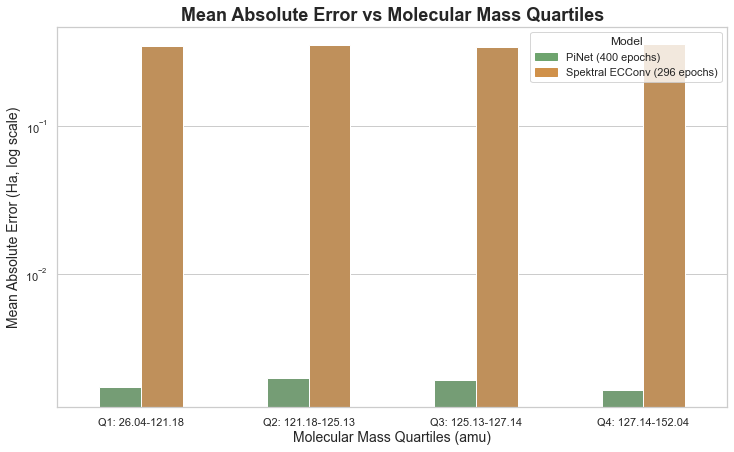

In [233]:
# Function to calculate mass bins and mean absolute error
def process_data(df, name):
    df['mass_bin'] = pd.cut(df['molecule_mass'], bins=bin_edges_mass, labels=quartile_labels_mass)
    grouped_data = df.groupby('mass_bin')['abs_error'].mean().reset_index()
    grouped_data['model'] = name
    return grouped_data

# Calculate quartiles for molecule_mass
q1_mass = PiNet_400epochs['molecule_mass'].quantile(0.25)
q2_mass = PiNet_400epochs['molecule_mass'].quantile(0.5)
q3_mass = PiNet_400epochs['molecule_mass'].quantile(0.75)

# Define bin edges using quartiles for molecule_mass
bin_edges_mass = [PiNet_400epochs['molecule_mass'].min(), q1_mass, q2_mass, q3_mass, PiNet_400epochs['molecule_mass'].max()]

# Create quartile labels with mass ranges for molecule_mass
quartile_labels_mass = [f'Q1: {bin_edges_mass[0]:.2f}-{bin_edges_mass[1]:.2f}',
                        f'Q2: {bin_edges_mass[1]:.2f}-{bin_edges_mass[2]:.2f}',
                        f'Q3: {bin_edges_mass[2]:.2f}-{bin_edges_mass[3]:.2f}',
                        f'Q4: {bin_edges_mass[3]:.2f}-{bin_edges_mass[4]:.2f}']

# Process both datasets
grouped_data_mass_PiNet = process_data(PiNet_400epochs, 'PiNet_400epochs')
grouped_data_mass_Spektral = process_data(Spektral_296epochs, 'Spektral_296epochs')

# Combine the two DataFrames
combined_data = pd.concat([grouped_data_mass_PiNet, grouped_data_mass_Spektral], ignore_index=True)

custom_colours = ['#6ea46e', '#d0914a']
# Plot the bar chart for molecule_mass
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))
bar_plot_mass = sns.barplot(x='mass_bin', y='abs_error', hue='model', data=combined_data, palette=custom_colours, width=0.5)

# Set axis labels and title
plt.xlabel('Molecular Mass Quartiles (amu)', fontsize=14)
plt.ylabel('Mean Absolute Error (Ha, log scale)', fontsize=14)
plt.title('Mean Absolute Error vs Molecular Mass Quartiles', fontsize=18, fontweight='bold')

new_labels = ['PiNet (400 epochs)', 'Spektral ECConv (296 epochs)']
new_colors = ['#6ea46e', '#d0914a']
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(new_labels, new_colors)]
plt.legend(title='Model', handles=patches)

plt.yscale('log')
# plt.ylim(top=3)
save_plot('MAE vs molecular mass quartiles')
plt.show()


MAE vs num heavy atoms


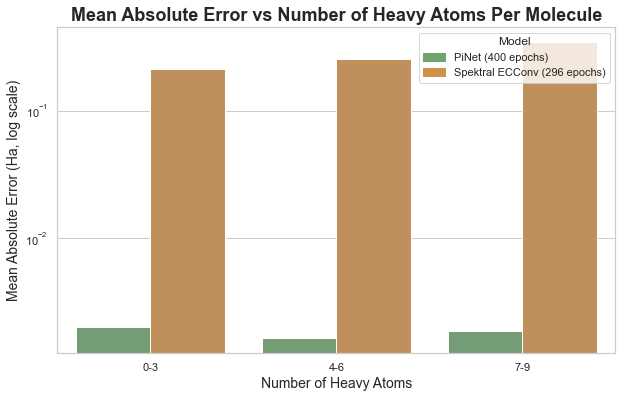

In [234]:
# Define bin edges for num_heavy_atoms
bin_edges_atoms = [0, 3, 6, 9]

# Create range labels for num_heavy_atoms
range_labels_atoms = ['0-3', '4-6', '7-9']

# Create a new column with the bins and labels for num_heavy_atoms in both DataFrames
for df, name in zip([PiNet_400epochs, Spektral_296epochs], ['PiNet_400epochs', 'Spektral_296epochs']):
    df['atoms_bin'] = pd.cut(df['num_heavy_atoms'], bins=bin_edges_atoms, labels=range_labels_atoms, include_lowest=True)
    df['source'] = name

# Concatenate the DataFrames
combined_data = pd.concat([PiNet_400epochs, Spektral_296epochs])

# Calculate the mean absolute error for each bin of num_heavy_atoms and source
grouped_data_atoms = combined_data.groupby(['atoms_bin', 'source'])['abs_error'].mean().reset_index()

# Plot the bar chart for num_heavy_atoms
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

custom_colours = ['#6ea46e', '#d0914a']
bar_plot_atoms = sns.barplot(x='atoms_bin', y='abs_error', hue='source', palette=custom_colours, data=grouped_data_atoms)

# Set axis labels and title
plt.xlabel('Number of Heavy Atoms', fontsize=14)
plt.ylabel('Mean Absolute Error (Ha, log scale)', fontsize=14)
plt.title('Mean Absolute Error vs Number of Heavy Atoms Per Molecule', fontsize=18, fontweight='bold')
plt.yscale('log')
new_labels = ['PiNet (400 epochs)', 'Spektral ECConv (296 epochs)']
new_colors = ['#6ea46e', '#d0914a']
import matplotlib.patches as mpatches
patches = [mpatches.Patch(color=color, label=label) for label, color in zip(new_labels, new_colors)]
plt.legend(title='Model', handles=patches)
save_plot('MAE vs num heavy atoms')
plt.show()

## GPU Training times

In [271]:
NVIDIA_pinet_1_epoch, NVIDIA_pinet_1_batch = get_PiNet_TF2_data('kpWVpD6sQIqR8Izm6XQtzg', 'left')
NVIDIA_pinet_10_epochs, NVIDIA_pinet_10_batch = get_PiNet_TF2_data('fEwUWZAbR3ab9tZwv6KSgA', 'left')
NVIDIA_pinet_100_epoch, NVIDIA_pinet_100_batch = get_PiNet_TF2_data('ujjcwYy3Q9ilRxmNFBN96A', 'left')

NVIDIA_spektral_1 = get_spektral_data('rk4I67NlS1uY0jkMVLjvHA', 'outer')
NVIDIA_spektral_10 = get_spektral_data('Y2mY5ZndQVCB4wN3LTGMNQ', 'outer')
NVIDIA_spektral_100 = get_spektral_data('B8pwi70OR5ynopUrUMVxcg', 'outer')
NVIDIA_spektral_14 = get_spektral_data('7XtG5RmQSJW4lIJJfQuwKg', 'outer')

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:86: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_batch_data = pd.merge(merged_batch_data, tag_dfs[i], on='step', how=mergetype)
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq

The column is monotonically increasing.
The column is monotonically increasing.
Non-monotonic indices:
[1755]
The column is monotonically increasing.


In [35]:
M1_pinet_1_epoch, M1_pinet_1_batch = get_PiNet_TF2_data('Gnr1JONfRSaS64L950VqYg', 'left') 
M1_pinet_10_epochs, M1_pinet_10_batch = get_PiNet_TF2_data('hAvVAsE4TW6enVKxKGkLcw', 'left')
M1_spektral_1 = get_spektral_data('mQAR6W1WS0qOurFOBj9Bqg', 'outer') 
M1_spektral_10 = get_spektral_data('903sQ50RR76H8e04RoBvsA', 'outer')

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:86: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_batch_data = pd.merge(merged_batch_data, tag_dfs[i], on='step', how=mergetype)
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq

The column is monotonically increasing.
The column is monotonically increasing.


In [36]:
M1_pinet_earlystopping_epoch_data, M1_pinet_earlystopping_batch_data = get_PiNet_TF2_data('xjSvUd34Rmek2dzbvBYWvA', 'left')
NVIDIA_pinet_earlystopping_epoch, NVIDIA_pinet_earlystopping_batch = get_PiNet_TF2_data('8e0JKF04QwGd9YkAXFqNAQ', 'left')
M1_spektral_earlystopping_data = get_spektral_data('lAsr83daTg2UQ4Vo06uO6g', 'outer')
NVIDIA_GPU_Spektral_earlystopping_data = get_spektral_data('NAD4MRLUQeeKPiyrgsQ9WQ', 'outer')
NVIDIA_GPU_Spektral_earlystopping_data.sort_values('wall_time', inplace=True)

/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:35: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_epoch_data = pd.merge(merged_epoch_data, tag_dfs[i], on='step')
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq/T/ipykernel_51777/1423463569.py:86: FutureWarning: Passing 'suffixes' which cause duplicate columns {'wall_time_x'} in the result is deprecated and will raise a MergeError in a future version.
  merged_batch_data = pd.merge(merged_batch_data, tag_dfs[i], on='step', how=mergetype)
/var/folders/2r/53clw21s5zv7ml4w3_xhd8v40000gq

The column is monotonically increasing.
Non-monotonic indices:
[438]


In [274]:
def extract_traintime(df):
    df['wall_time'] -= df['wall_time'].iloc[0]
    return df['wall_time'].iloc[-1]

# Create a list of dataframes and their corresponding labels
dataframes = [
    (NVIDIA_pinet_1_batch, 'NVIDIA', 'PiNet', 1),
    (NVIDIA_pinet_10_batch, 'NVIDIA', 'PiNet', 10),
    (NVIDIA_pinet_100_batch, 'NVIDIA', 'PiNet', 100),
    (NVIDIA_spektral_1, 'NVIDIA', 'Spektral ECConv', 1),
    (NVIDIA_spektral_10, 'NVIDIA', 'Spektral ECConv', 10),
    (NVIDIA_spektral_100, 'NVIDIA', 'Spektral ECConv', 100),
    (M1_pinet_1_batch, 'M1', 'PiNet', 1),
    (M1_pinet_10_batch, 'M1', 'PiNet', 10),
    (M1_spektral_1, 'M1', 'Spektral ECConv', 1),
    (M1_spektral_10, 'M1', 'Spektral ECConv', 10),
    (M1_pinet_earlystopping_batch_data, 'M1', 'PiNet', 14),
    (M1_spektral_earlystopping_data, 'M1', 'Spektral ECConv', 14),   
    (NVIDIA_pinet_earlystopping_batch, 'NVIDIA', 'PiNet', 14),
    (NVIDIA_spektral_14, 'NVIDIA', 'Spektral ECConv', 14)
]

# Create a new dataframe containing training times for each combination
results = []

for df, system, network, epochs in dataframes:
    traintime = extract_traintime(df)
    results.append({'System': system, 'Network': network, 'Epochs': epochs, 'Training Time': traintime})

results_df = pd.DataFrame(results)


Training Time Comparison for Pinet and Spektral ECConv Networks on NVIDIA and M1 GPUs


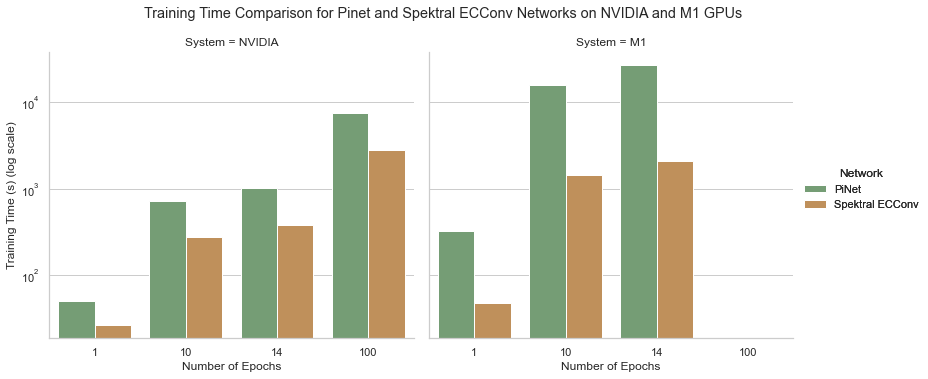

In [275]:
# Plot the bar chart using seaborn
g = sns.catplot(x='Epochs', y='Training Time', hue='Network', data=results_df, col='System', kind='bar', palette=colour_map.values())

# Customize the plot
g.fig.suptitle('Training Time Comparison for Pinet and Spektral ECConv Networks on NVIDIA and M1 GPUs', y=1.05)
g.set_axis_labels('Number of Epochs', 'Training Time (s) (log scale)')
g.add_legend(title='Network')

# Show the plot
plt.yscale('log')
save_plot('Training Time Comparison for Pinet and Spektral ECConv Networks on NVIDIA and M1 GPUs')
plt.show()


## GPU Performance Comparison

In [51]:
def get_M1_GPU_PiNet_TF2_data(experiment_id, filepath, mergetype):
    merged_epoch_data, merged_batch_data = get_PiNet_TF2_data(experiment_id, mergetype)
    pwrdata = get_pwr_data(filepath)
    batch_and_pwr_data = merge_with_pwr_data(merged_batch_data, pwrdata)
    return merged_epoch_data, batch_and_pwr_data

In [ ]:
M1_pinet_earlystopping_epoch, M1_pinet_earlystopping_batchpwr = get_M1_GPU_PiNet_TF2_data('xjSvUd34Rmek2dzbvBYWvA', '/Users/miguelnavaharris/New_Benchmarks/Prediction_accuracy/M1/Rescaled_correctly/PiNet_14_epochs_256_dressnoscale/PwrData 2023-04-15 at 00.48.39.csv', 'left')
M1_pinet_earlystopping_batchpwr


NVIDIA_pinet_earlystopping_epoch, NVIDIA_pinet_earlystopping_batch = get_PiNet_TF2_data('8e0JKF04QwGd9YkAXFqNAQ', 'left')
NVIDIA_pinet_earlystopping_GPU_data = get_NVIDIA_GPU_data('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/PiNet_rescaled_correctly/earlystopping/another_with_gpumetrics_patience_5_epochs_dress_noscale/gpu_metrics.csv')
NVIDIA_pinet_earlystopping_batchpwr = merge_with_pwr_data(NVIDIA_pinet_earlystopping_batch, NVIDIA_pinet_earlystopping_GPU_data)

M1_spektral_earlystopping_data = get_spektral_data('lAsr83daTg2UQ4Vo06uO6g', 'outer')
M1_spektral_earlystopping_pwrdata = get_pwr_data('/Users/miguelnavaharris/New_Benchmarks/Prediction_accuracy/M1/Spektral_28epochs/PwrData 2023-04-11 at 18.39.23.csv')
M1_spektral_all_data = merge_with_pwr_data(M1_spektral_earlystopping_data, M1_spektral_earlystopping_pwrdata)
M1_spektral_all_data.index = M1_spektral_earlystopping_data.index

NVIDIA_GPU_Spektral_earlystopping_data = get_spektral_data('NAD4MRLUQeeKPiyrgsQ9WQ', 'outer')
NVIDIA_GPU_Spektral_earlystopping_data.sort_values('wall_time', inplace=True)
filepath = '/Users/miguelnavaharris/New_Benchmarks/NVIDIA/Spektral/28_epochs_earlystopping_256_lrdecay/gpu_metrics.csv'
NVIDIA_Spektral_28epochs_GPU_data = get_NVIDIA_GPU_data(filepath)
NVIDIA_GPU_Spektral_earlystopping_all_data = merge_with_pwr_data(NVIDIA_GPU_Spektral_earlystopping_data, NVIDIA_Spektral_28epochs_GPU_data)
NVIDIA_GPU_Spektral_earlystopping_all_data.index = NVIDIA_GPU_Spektral_earlystopping_data.index

# Remove str from power draw values
NVIDIA_pinet_earlystopping_batchpwr[' power.draw [W]'] = NVIDIA_pinet_earlystopping_batchpwr[' power.draw [W]'].str.replace(' W', '').astype(float)
NVIDIA_GPU_Spektral_earlystopping_all_data[' power.draw [W]'] = NVIDIA_GPU_Spektral_earlystopping_all_data[' power.draw [W]'].str.replace(' W', '').astype(float)
def remove_non_numeric(value):
    return float(re.sub('[^0-9.]', '', value))

NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.gpu [%]'] = NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.gpu [%]'].apply(remove_non_numeric)
NVIDIA_pinet_earlystopping_batchpwr[' utilization.gpu [%]'] = NVIDIA_pinet_earlystopping_batchpwr[' utilization.gpu [%]'].apply(remove_non_numeric)
NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.memory [%]'] = NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.memory [%]'].apply(remove_non_numeric)
NVIDIA_pinet_earlystopping_batchpwr[' utilization.memory [%]'] = NVIDIA_pinet_earlystopping_batchpwr[' utilization.memory [%]'].apply(remove_non_numeric)
NVIDIA_GPU_Spektral_earlystopping_all_data[' memory.used [MiB]'] = NVIDIA_GPU_Spektral_earlystopping_all_data[' memory.used [MiB]'].apply(remove_non_numeric)
NVIDIA_pinet_earlystopping_batchpwr[' memory.used [MiB]'] = NVIDIA_pinet_earlystopping_batchpwr[' memory.used [MiB]'].apply(remove_non_numeric)

In [ ]:
def plot_memory_usage(df, network, batch_size):
    df_batch = df[df['batch_size'] == batch_size]
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_batch, x='training_step', y='RAM_usage_MB', label='RAM Usage (MB)')
    sns.lineplot(data=df_batch, x='training_step', y='Swap_usage_MB', label='Swap Memory Usage (MB)')
    plt.xlabel("Training Step", fontsize=14)
    plt.ylabel("Memory Usage (MB)", fontsize=14)
    plt.title(f"{network} Memory Use Over 3 Epochs (Batch Size: {batch_size})", fontsize=16)
    plt.legend()
    # save_plot(f"{network} Memory Use Over 3 Epochs (Batch Size: {batch_size})")
    plt.show()

M1 GPU: Spektral ECConv Memory Use Over 14 Epochs


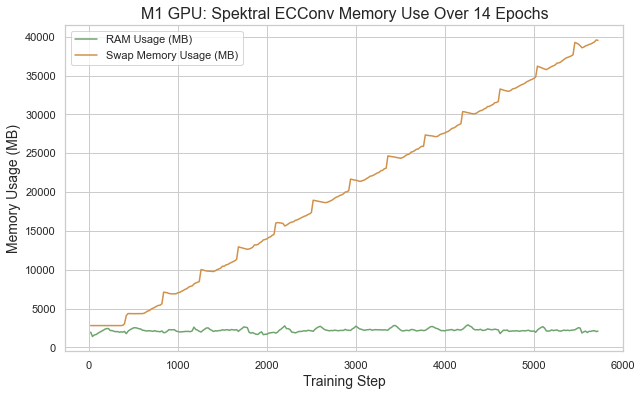

In [193]:
plt.figure(figsize=(10,6))
sns.lineplot(data=M1_spektral_all_data, x=M1_spektral_all_data.index, y='RAM_usage_MB', label='RAM Usage (MB)')
sns.lineplot(data=M1_spektral_all_data, x=M1_spektral_all_data.index, y='Swap_usage_MB', label='Swap Memory Usage (MB)')
plt.title(f"M1 GPU: Spektral ECConv Memory Use Over 14 Epochs", fontsize=16)
plt.xlabel("Training Step", fontsize=14)
plt.ylabel("Memory Usage (MB)", fontsize=14)
save_plot(f"M1 GPU: Spektral ECConv Memory Use Over 14 Epochs")

M1 GPU: PiNet Memory Use Over 14 Epochs


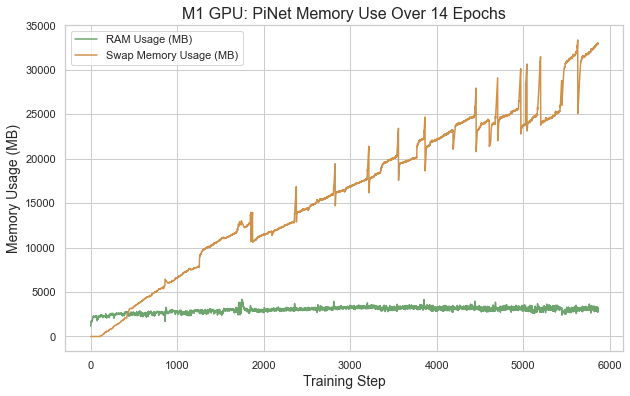

In [192]:
alpha = 1
M1_pinet_earlystopping_batchpwr['smoothed_ram_usage_mb'] = M1_pinet_earlystopping_batchpwr['batch_ram_usage_mb'].ewm(alpha=alpha).mean()
M1_pinet_earlystopping_batchpwr['smoothed_swap_usage_mb'] = M1_pinet_earlystopping_batchpwr['batch_swap_usage_mb'].ewm(alpha=alpha).mean()

plt.figure(figsize=(10,6))
sns.lineplot(data=M1_pinet_earlystopping_batchpwr, x=M1_pinet_earlystopping_batchpwr.index, y='smoothed_ram_usage_mb', label='RAM Usage (MB)')
sns.lineplot(data=M1_pinet_earlystopping_batchpwr, x=M1_pinet_earlystopping_batchpwr.index, y='smoothed_swap_usage_mb', label='Swap Memory Usage (MB)')
plt.title(f"M1 GPU: PiNet Memory Use Over 14 Epochs", fontsize=16)
plt.xlabel("Training Step", fontsize=14)
plt.ylabel("Memory Usage (MB)", fontsize=14)
save_plot("M1 GPU: PiNet Memory Use Over 14 Epochs")

Index(['wall_time', ' utilization.gpu [%]', ' utilization.memory [%]',
       ' memory.total [MiB]', ' memory.free [MiB]', ' memory.used [MiB]',
       ' power.draw [W]', ' temperature.gpu', ' clocks.current.sm [MHz]'],
      dtype='object')


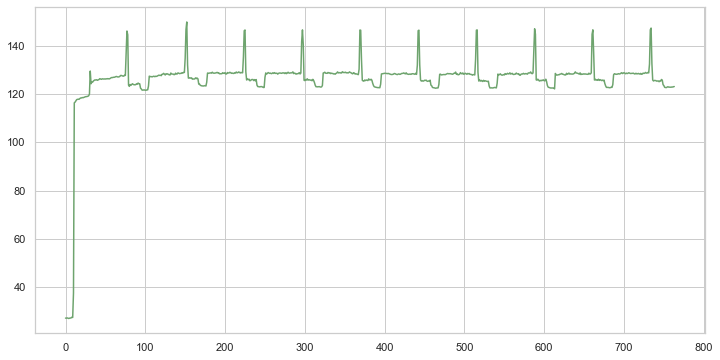

In [130]:
# Same power draw pattern occurs when callbacks are disabled
nocallbacks = get_NVIDIA_GPU_data('/Users/miguelnavaharris/New_Benchmarks/updatefreq_40/1_epochs_dressnoscale/gpu_metrics.csv')
print(nocallbacks.columns)
nocallbacks[' power.draw [W]'] = nocallbacks[' power.draw [W]'].apply(remove_non_numeric)
plt.plot(nocallbacks.index, nocallbacks[' power.draw [W]'])

In [85]:
M1_pinet_earlystopping_batchpwr['moleculespersec/Watt'] = M1_pinet_earlystopping_batchpwr['batch_moleculespersec'] / M1_pinet_earlystopping_batchpwr[' GPU Power (Watt)']

In [98]:
M1_pinet_earlystopping_batchpwr['moleculespersec/Watt'] = M1_pinet_earlystopping_batchpwr['moleculespersec/Watt'].replace(np.inf, np.nan).dropna()

M1 GPU Moleculespersec vs Training Step: 14 Epochs


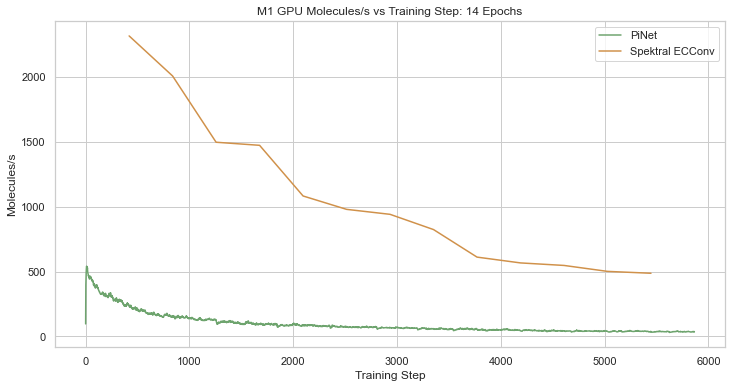

In [104]:
ewma_alpha = 0.1  # Choose an alpha value for the EWMA; you can adjust this as needed
M1_pinet_earlystopping_batchpwr_ewma = M1_pinet_earlystopping_batchpwr['batch_moleculespersec'].ewm(alpha=ewma_alpha).mean()
M1_spektral_all_data_ewma = M1_spektral_all_data['epoch_moleculespersec'] #.ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': M1_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': M1_spektral_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('M1 GPU Molecules/s vs Training Step: 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('Molecules/s')
save_plot('M1 GPU Moleculespersec vs Training Step: 14 Epochs')
plt.show()


NVIDIA GPU Moleculespersec vs Training Step: 14 Epochs


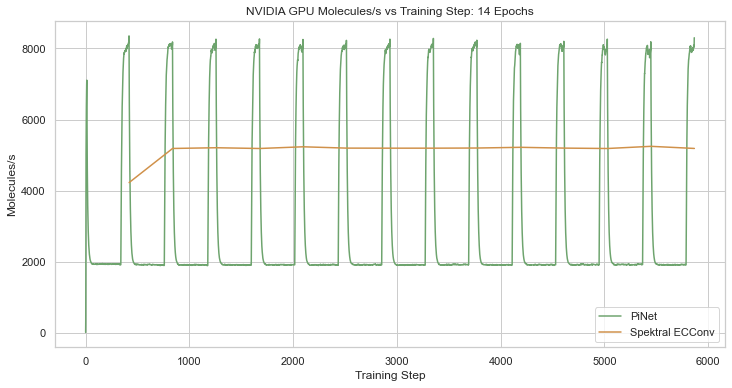

In [146]:
ewma_alpha = 0.1  # Choose an alpha value for the EWMA; you can adjust this as needed
NVIDIA_pinet_earlystopping_batchpwr_ewma = NVIDIA_pinet_earlystopping_batchpwr['batch_moleculespersec'].ewm(alpha=ewma_alpha).mean()
NVIDIA_GPU_Spektral_earlystopping_all_data_ewma = NVIDIA_GPU_Spektral_earlystopping_all_data['epoch_moleculespersec'].dropna().iloc[:14] #.ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': NVIDIA_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': NVIDIA_GPU_Spektral_earlystopping_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('NVIDIA GPU Molecules/s vs Training Step: 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('Molecules/s')
save_plot('NVIDIA GPU Moleculespersec vs Training Step: 14 Epochs')
plt.show()

M1 GPU power draw: 14 epochs


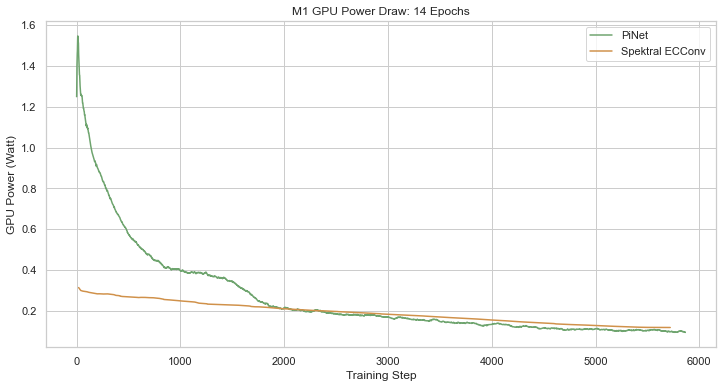

In [53]:
ewma_alpha = 0.01  # Choose an alpha value for the EWMA; you can adjust this as needed
M1_pinet_earlystopping_batchpwr_ewma = M1_pinet_earlystopping_batchpwr[' GPU Power (Watt)'].ewm(alpha=ewma_alpha).mean()
M1_spektral_all_data_ewma = M1_spektral_all_data[' GPU Power (Watt)'].ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': M1_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': M1_spektral_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('M1 GPU Power Draw: 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('GPU Power (Watt)')
save_plot('M1 GPU power draw: 14 epochs')
plt.show()


M1 GPU utilisation %: 14 epochs


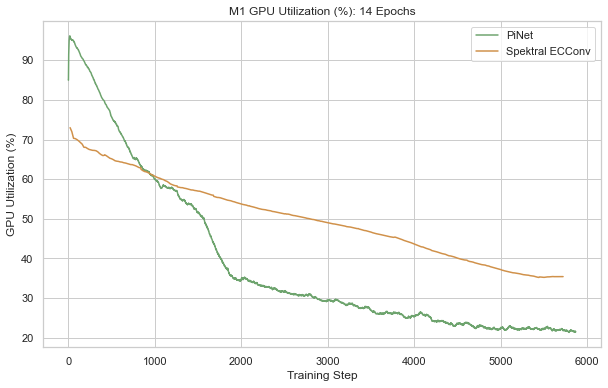

In [205]:
ewma_alpha = 0.01  # Choose an alpha value for the EWMA; you can adjust this as needed
M1_pinet_earlystopping_batchpwr_ewma = M1_pinet_earlystopping_batchpwr[' GPU Utilization (%)'].ewm(alpha=ewma_alpha).mean()
M1_spektral_all_data_ewma = M1_spektral_all_data[' GPU Utilization (%)'].ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': M1_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': M1_spektral_all_data_ewma})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", palette=colour_map.values())
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('M1 GPU Utilization (%): 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('GPU Utilization (%)')
save_plot('M1 GPU utilisation %: 14 epochs')
plt.show()

In [ ]:
def extract_powerdraw_spektral(df, epochs):
    epoch_index = df['epoch_validation_MAE'].dropna().index[epochs - 1]
    return df[[' power.draw [W]']].loc[:epoch_index]

NVIDIA GPU power draw: 14 epochs


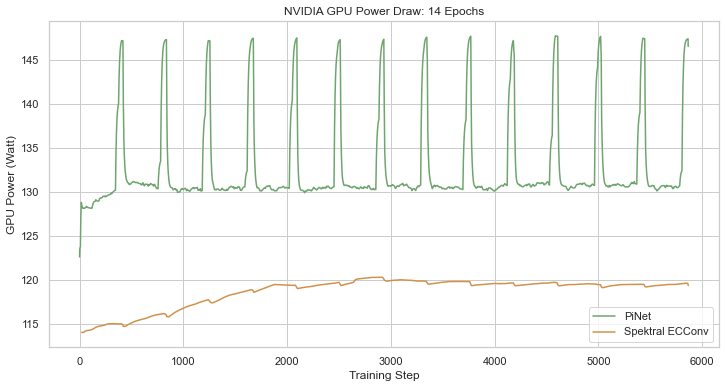

In [148]:
NVIDIA_GPU_Spektral_earlystopping_all_data = NVIDIA_GPU_Spektral_earlystopping_all_data.loc[~NVIDIA_GPU_Spektral_earlystopping_all_data.index.duplicated()] # Remove duplicated row
ewma_alpha = 0.1  # Choose an alpha value for the EWMA; you can adjust this as needed

NVIDIA_pinet_earlystopping_batchpwr_ewma = NVIDIA_pinet_earlystopping_batchpwr[' power.draw [W]'].ewm(alpha=ewma_alpha).mean()
NVIDIA_GPU_Spektral_earlystopping_all_data_ewma = NVIDIA_GPU_Spektral_earlystopping_all_data[' power.draw [W]'].loc[:5866].ewm(alpha=ewma_alpha).mean() 
combined_ewma = pd.DataFrame({'PiNet': NVIDIA_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': NVIDIA_GPU_Spektral_earlystopping_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('NVIDIA GPU Power Draw: 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('GPU Power (Watt)')
save_plot('NVIDIA GPU power draw: 14 epochs')
plt.show()

NVIDIA GPU Utilisation: 14 epochs


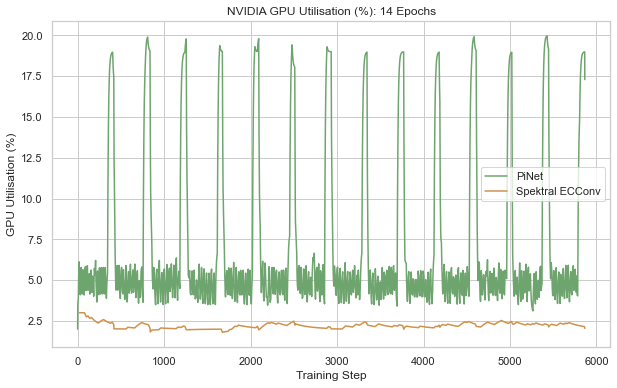

In [207]:
NVIDIA_GPU_Spektral_earlystopping_all_data = NVIDIA_GPU_Spektral_earlystopping_all_data.loc[~NVIDIA_GPU_Spektral_earlystopping_all_data.index.duplicated()] # Remove duplicated row
ewma_alpha = 0.1  # Choose an alpha value for the EWMA; you can adjust this as needed
NVIDIA_pinet_earlystopping_batchpwr_ewma = NVIDIA_pinet_earlystopping_batchpwr[' utilization.gpu [%]'].ewm(alpha=ewma_alpha).mean()
NVIDIA_GPU_Spektral_earlystopping_all_data_ewma = NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.gpu [%]'].loc[:5866].ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': NVIDIA_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': NVIDIA_GPU_Spektral_earlystopping_all_data_ewma})
plt.figure(figsize=(10,6))
sns.set(style="whitegrid", palette=colour_map.values())
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('NVIDIA GPU Utilisation (%): 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('GPU Utilisation (%)')
save_plot('NVIDIA GPU Utilisation: 14 epochs')
plt.show()

In [194]:
NVIDIA_pinet_earlystopping_batchpwr[' utilization.gpu [%]'].mean()

7.165871121718377

In [197]:
NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.memory [%]'].mean()

1.2300163132137032

NVIDIA GPU memory utilisation (%): 14 epochs


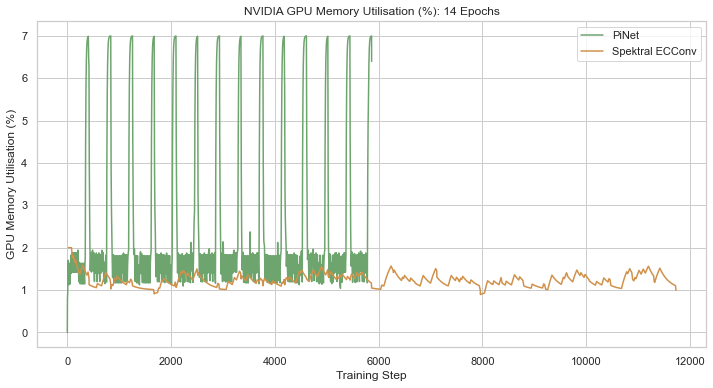

In [57]:
NVIDIA_GPU_Spektral_earlystopping_all_data = NVIDIA_GPU_Spektral_earlystopping_all_data.loc[~NVIDIA_GPU_Spektral_earlystopping_all_data.index.duplicated()] # Remove duplicated row
ewma_alpha = 0.1  # Choose an alpha value for the EWMA; you can adjust this as needed
NVIDIA_pinet_earlystopping_batchpwr_ewma = NVIDIA_pinet_earlystopping_batchpwr[' utilization.memory [%]'].ewm(alpha=ewma_alpha).mean()
NVIDIA_GPU_Spektral_earlystopping_all_data_ewma = NVIDIA_GPU_Spektral_earlystopping_all_data[' utilization.memory [%]'].ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': NVIDIA_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': NVIDIA_GPU_Spektral_earlystopping_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('NVIDIA GPU Memory Utilisation (%): 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('GPU Memory Utilisation (%)')
save_plot('NVIDIA GPU memory utilisation (%): 14 epochs')
plt.show()

NVIDIA GPU Memory Used: 14 epochs


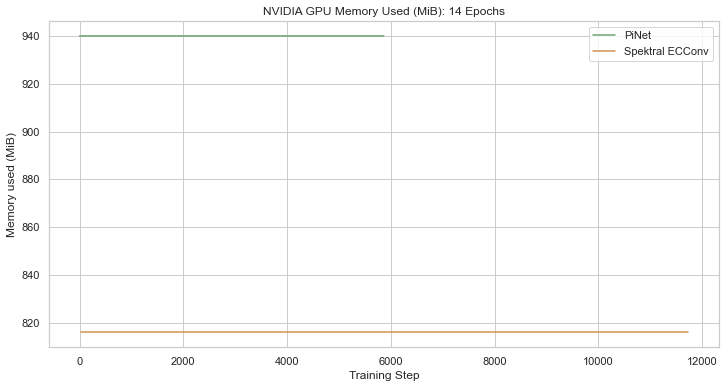

In [58]:
NVIDIA_GPU_Spektral_earlystopping_all_data = NVIDIA_GPU_Spektral_earlystopping_all_data.loc[~NVIDIA_GPU_Spektral_earlystopping_all_data.index.duplicated()] # Remove duplicated row
ewma_alpha = 0.1  
NVIDIA_pinet_earlystopping_batchpwr_ewma = NVIDIA_pinet_earlystopping_batchpwr[' memory.used [MiB]'].ewm(alpha=ewma_alpha).mean()
NVIDIA_GPU_Spektral_earlystopping_all_data_ewma = NVIDIA_GPU_Spektral_earlystopping_all_data[' memory.used [MiB]'].ewm(alpha=ewma_alpha).mean()
combined_ewma = pd.DataFrame({'PiNet': NVIDIA_pinet_earlystopping_batchpwr_ewma, 
                              'Spektral ECConv': NVIDIA_GPU_Spektral_earlystopping_all_data_ewma})
sns.set(style="whitegrid", palette=colour_map.values(), rc={'figure.figsize':(12, 6)})
sns.lineplot(data=combined_ewma, dashes=False)
plt.title('NVIDIA GPU Memory Used (MiB): 14 Epochs')
plt.xlabel('Training Step')
plt.ylabel('Memory used (MiB)')
save_plot('NVIDIA GPU Memory Used: 14 epochs')
plt.show()

## Clearing Memory

In [59]:
M1_GPU_PiNet100molsdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/Garbage_collection/PiNet_TF2_M1_GPU_100mols_gc_memory_usage.csv')
M1_GPU_PiNet1000molsdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/Garbage_collection/PiNet_TF2_M1_GPU_1000mols_gc_memory_usage.csv')
M1_GPU_simplekerasdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/Garbage_collection/simplekeras_memory_usage.csv')

/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


Garbage collection M1 GPU


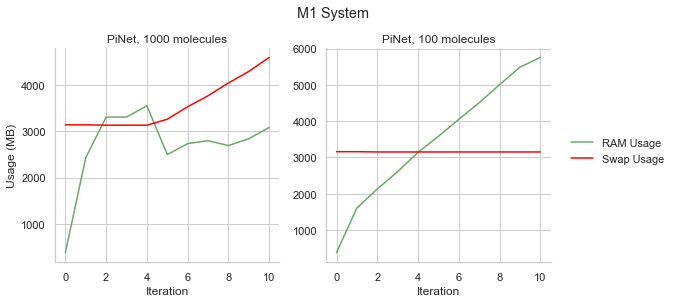

In [208]:
M1_GPU_PiNet1000molsdata['Model'] = 'PiNet, 1000 molecules'
M1_GPU_PiNet100molsdata['Model'] = 'PiNet, 100 molecules'
M1_GPU_simplekerasdata['Model'] = 'Simple Keras Training Script'

data = pd.concat([M1_GPU_PiNet1000molsdata, M1_GPU_PiNet100molsdata])

def plot_lines(data):
    g = sns.FacetGrid(data, col='Model', height=4, aspect=1, sharey=False)
    g.map_dataframe(sns.lineplot, x='Iteration', y='Memory Usage (MB)', ci=None, label='RAM Usage')
    g.map_dataframe(sns.lineplot, x='Iteration', y='Swap Usage (MB)', ci=None, label='Swap Usage', color='red')
    g.set_axis_labels('Iteration', 'Usage (MB)')
    g.set_titles(col_template="{col_name}")
    g.add_legend()
    g.tight_layout()
    plt.suptitle('M1 System', y=1.05)
    save_plot('Garbage collection M1 GPU')
    plt.show()


plot_lines(data)


In [64]:
NVIDIA_GPU_PiNet100molsdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/gc_collect/PiNet_100mols.csv')
NVIDIA_GPU_PiNet1000molsdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/gc_collect/PiNet_1000mols.csv')
NVIDIA_GPU_simplekerasdata = pd.read_csv('/Users/miguelnavaharris/New_Benchmarks/NVIDIA/gc_collect/simplekeras.csv')

/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/Users/miguelnavaharris/miniforge3/envs/pinn/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


Garbage collection NVIDIA GPU


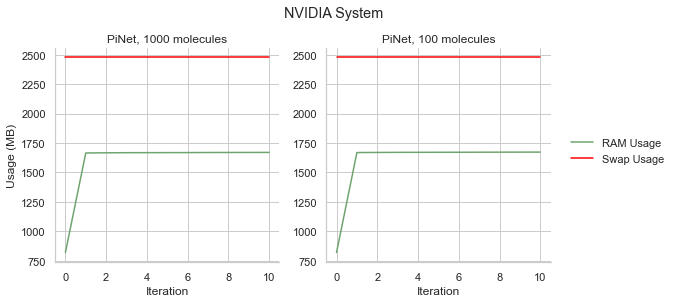

In [209]:
NVIDIA_GPU_PiNet1000molsdata['Model'] = 'PiNet, 1000 molecules'
NVIDIA_GPU_PiNet100molsdata['Model'] = 'PiNet, 100 molecules'
NVIDIA_GPU_simplekerasdata['Model'] = 'Simple Keras Training Script'

data = pd.concat([NVIDIA_GPU_PiNet1000molsdata, NVIDIA_GPU_PiNet100molsdata])

def plot_lines(data):
    g = sns.FacetGrid(data, col='Model', height=4, aspect=1, sharey=False)
    g.map_dataframe(sns.lineplot, x='Iteration', y='Memory Usage (MB)', ci=None, label='RAM Usage')
    g.map_dataframe(sns.lineplot, x='Iteration', y='Swap Usage (MB)', ci=None, label='Swap Usage', color='red')
    g.set_axis_labels('Iteration', 'Usage (MB)')
    g.set_titles(col_template="{col_name}")
    g.add_legend()
    g.tight_layout()
    plt.suptitle('NVIDIA System', y=1.05)
    save_plot('Garbage collection NVIDIA GPU')
    plt.show()


plot_lines(data)

